# Welcome!
Below, we will learn to implement and train a policy to play atari-pong, using only the pixels as input. We will use convolutional neural nets, multiprocessing, and pytorch to implement and train our policy. Let's get started!

(I strongly recommend you to try this notebook on the Udacity workspace first before running it locally on your desktop/laptop, as performance might suffer in different environments)

In [1]:
# install package for displaying animation
# !pip install JSAnimation
# !pip install gym
# custom utilies for displaying animation, collecting rollouts and more
import pong_utils

%matplotlib inline

# check which device is being used. 
# I recommend disabling gpu until you've made sure that the code runs
device = pong_utils.device
print("using device: ",device)

i found this devide: cuda:0
using device:  cuda:0


In [2]:
# render ai gym environment
import gym
import time

# PongDeterministic does not contain random frameskip
# so is faster to train than the vanilla Pong-v4 environment
env = gym.make('PongDeterministic-v4')

print("List of available actions: ", env.unwrapped.get_action_meanings())

# we will only use the actions 'RIGHTFIRE' = 4 and 'LEFTFIRE" = 5
# the 'FIRE' part ensures that the game starts again after losing a life
# the actions are hard-coded in pong_utils.py

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']


/media/Data/env/pong-env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


# Preprocessing
To speed up training, we can simplify the input by cropping the images and use every other pixel



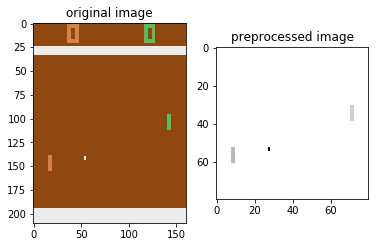

In [3]:
import matplotlib
import matplotlib.pyplot as plt

# show what a preprocessed image looks like
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    frame, _, _, _ = env.step(1)

plt.subplot(1,2,1)
plt.imshow(frame)
plt.title('original image')

plt.subplot(1,2,2)
plt.title('preprocessed image')

# 80 x 80 black and white image
plt.imshow(pong_utils.preprocess_single(frame), cmap='Greys')
plt.show()



# Policy

## Exercise 1: Implement your policy
 
Here, we define our policy. The input is the stack of two different frames (which captures the movement), and the output is a number $P_{\rm right}$, the probability of moving left. Note that $P_{\rm left}= 1-P_{\rm right}$

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F



# set up a convolutional neural net
# the output is the probability of moving right
# P(left) = 1-P(right)
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        
        
    ########
    ## 
    ## Modify your neural network
    ##
    ########
        
        # 80x80 to outputsize x outputsize
        # outputsize = (inputsize - kernel_size + stride)/stride 
        # (round up if not an integer)

        # output = 20x20 here
        # 80x80x2 to 38x38x4
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16
        
        # two fully connected layer
        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        # Sigmoid to 
        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))

# use your own policy!
policy=Policy().to(device)

# the course solution policy:
policy=pong_utils.Policy().to(device)

# we use the adam optimizer with learning rate 2e-4
# optim.SGD is also possible
import torch.optim as optim
optimizer = optim.Adam(policy.parameters(), lr=1e-4)

# Game visualization
pong_utils contain a play function given the environment and a policy. An optional preprocess function can be supplied. Here we define a function that plays a game and shows learning progress


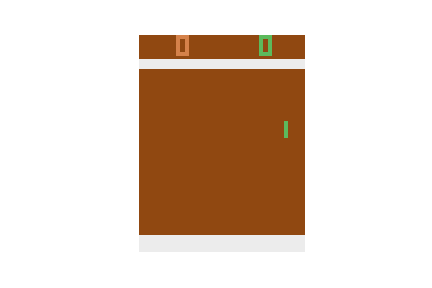
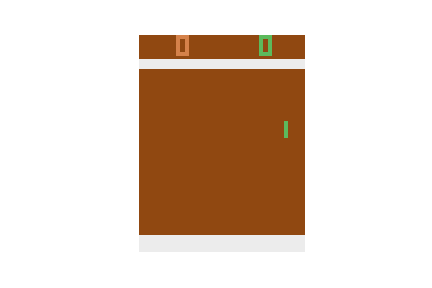
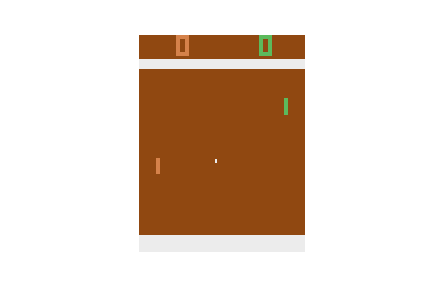
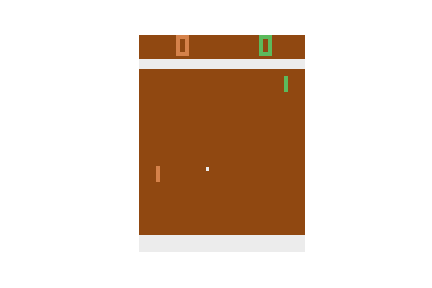
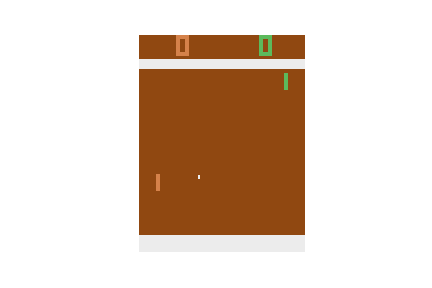
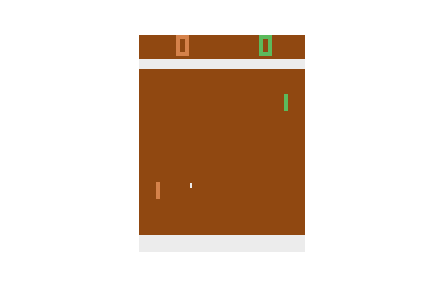
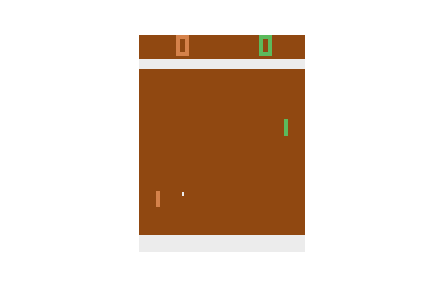
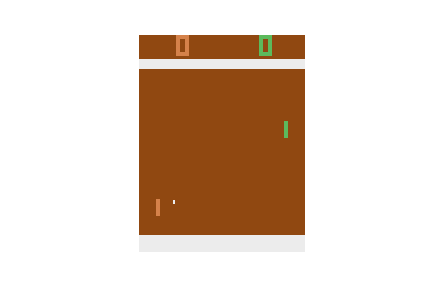
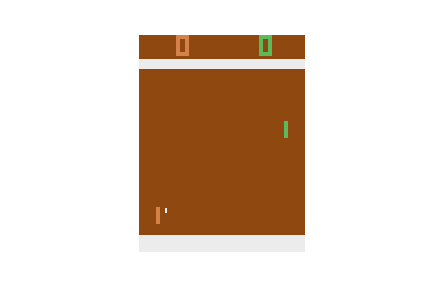
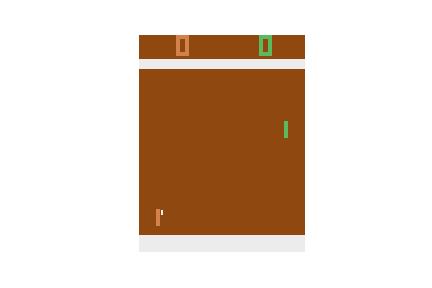
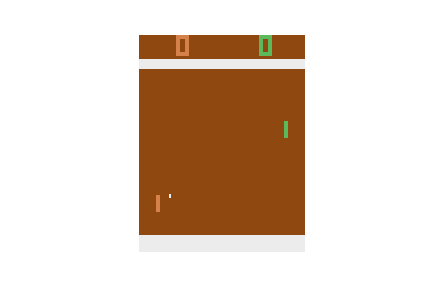
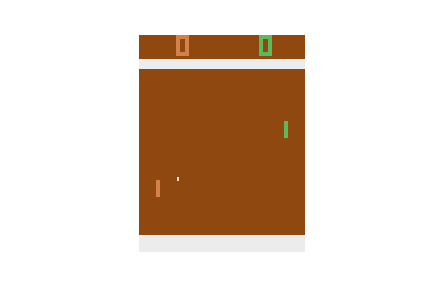
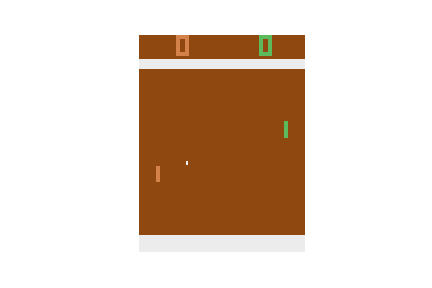
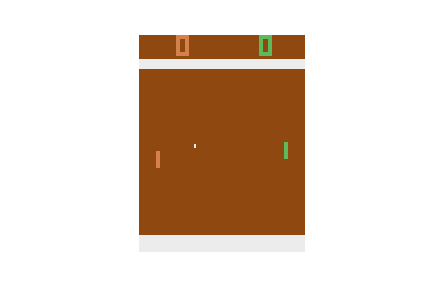
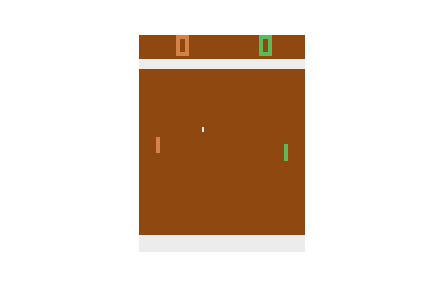
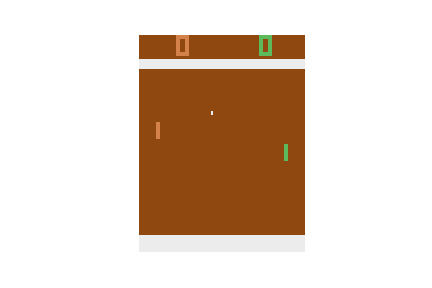
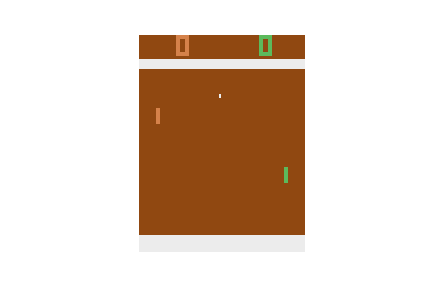
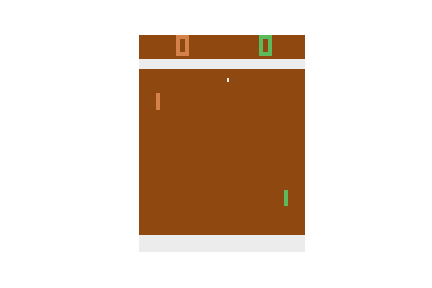
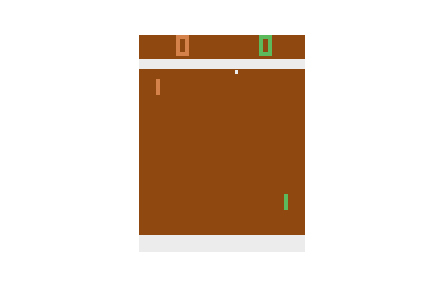
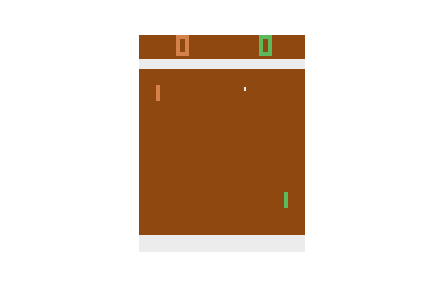
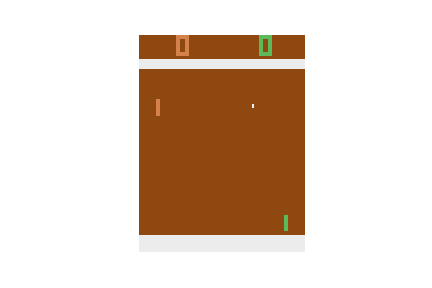
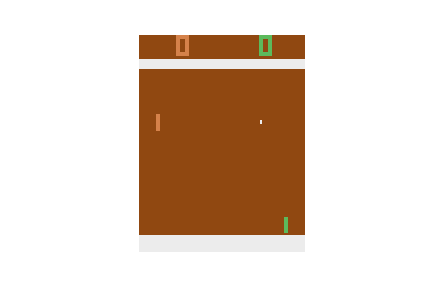
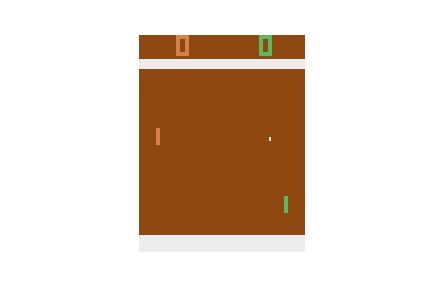
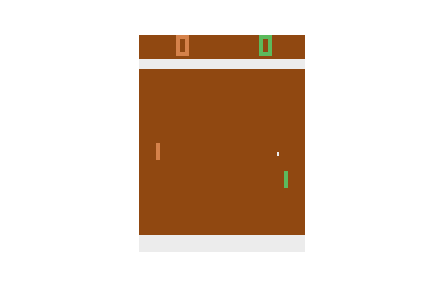
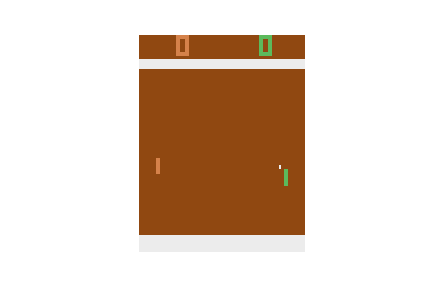
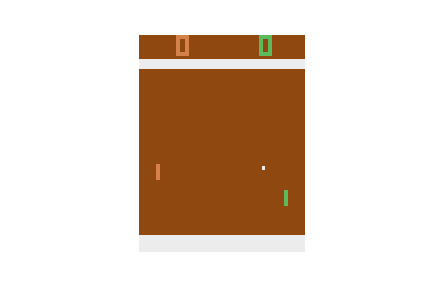
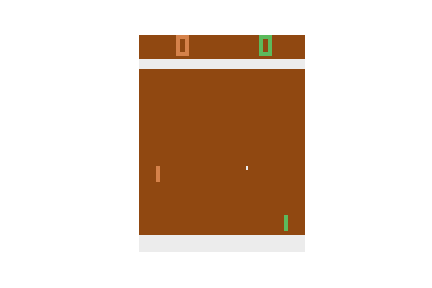
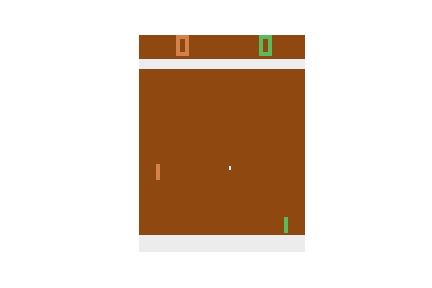
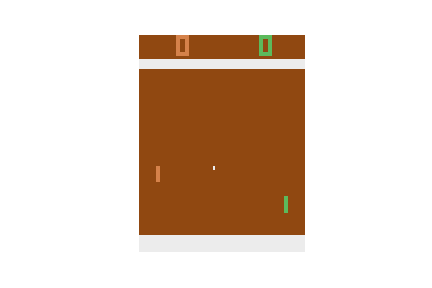
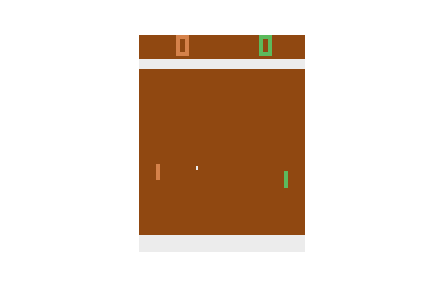
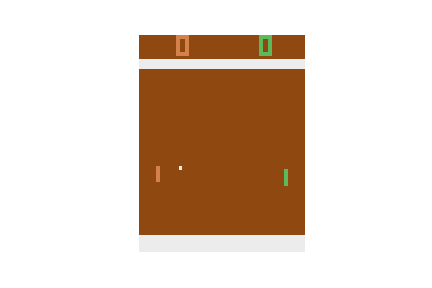
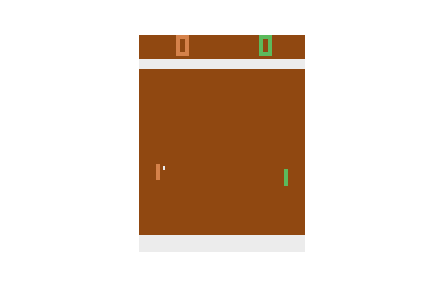
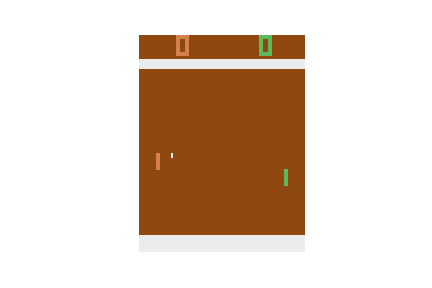
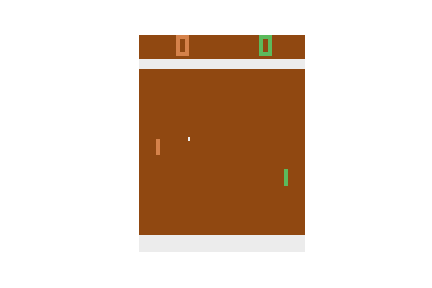
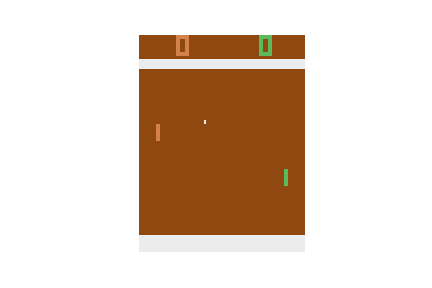
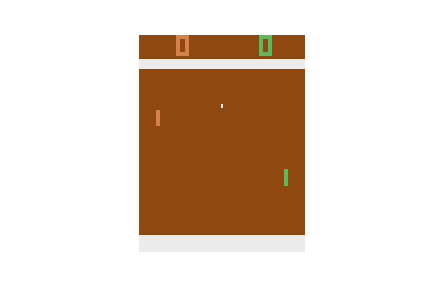
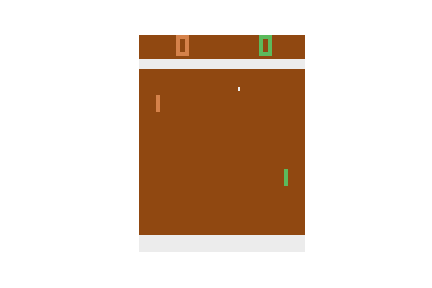
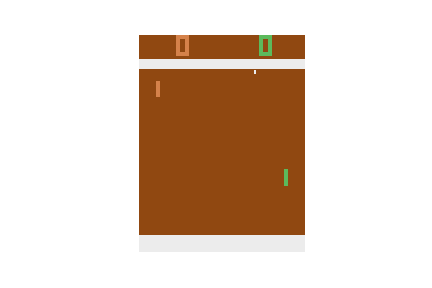
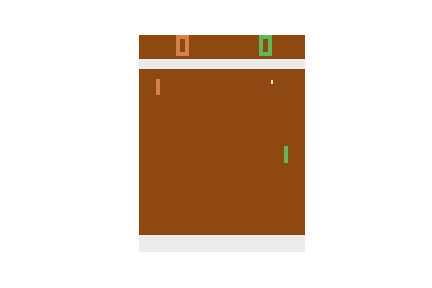
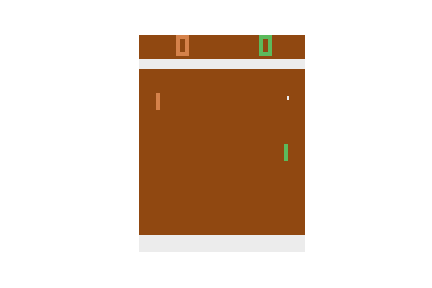
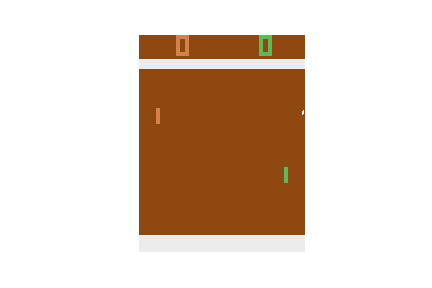
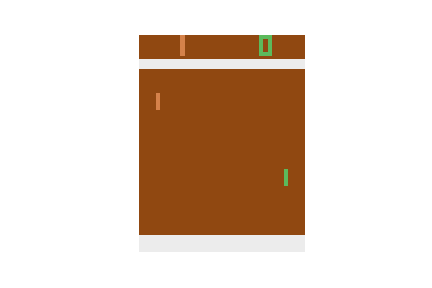
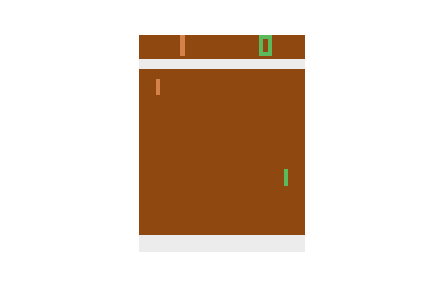
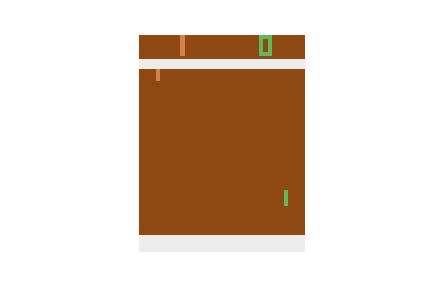
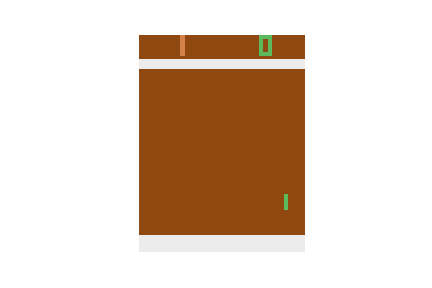
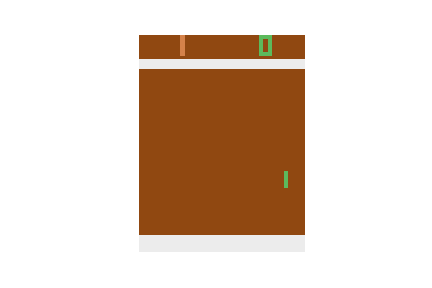
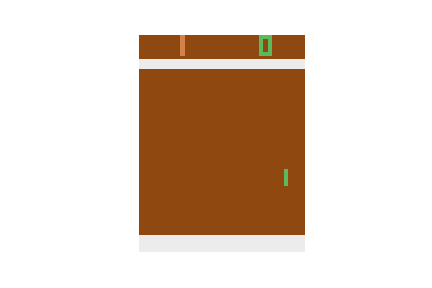
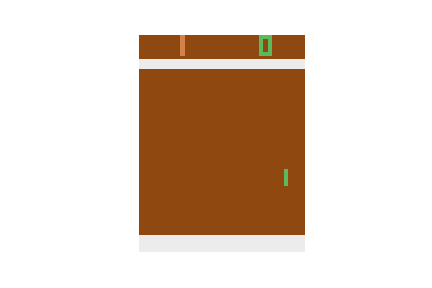
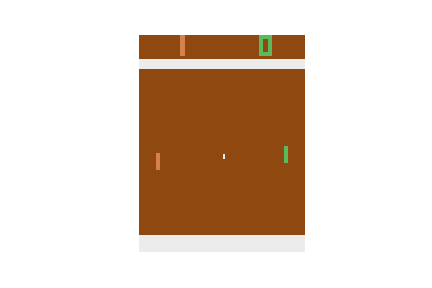
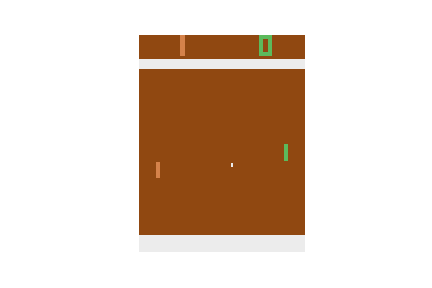
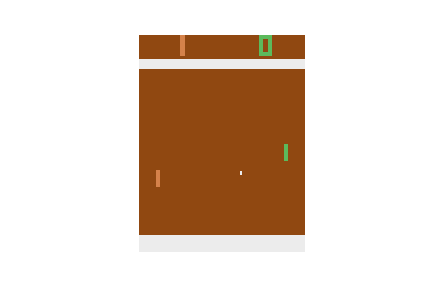
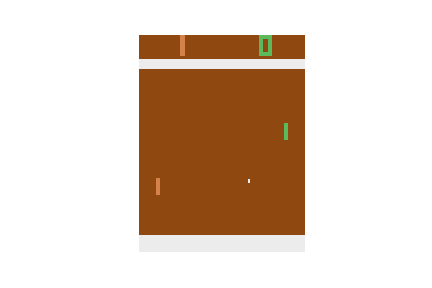
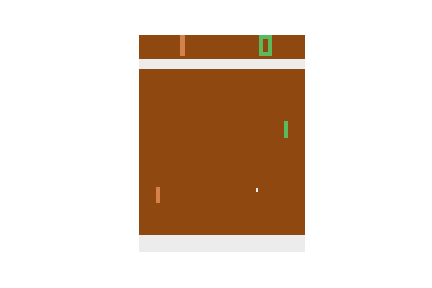
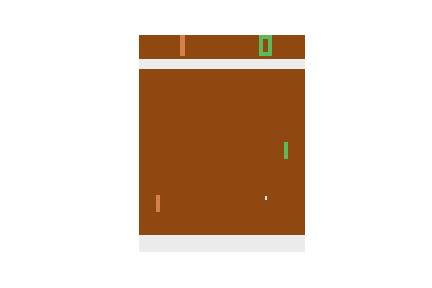
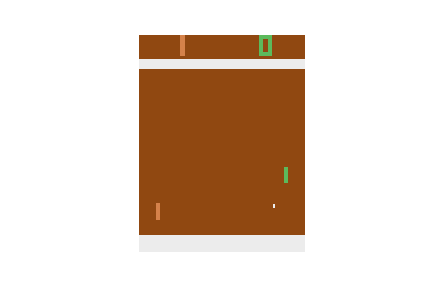
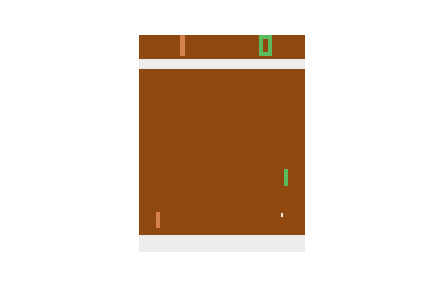
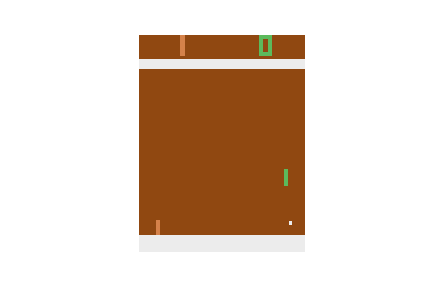
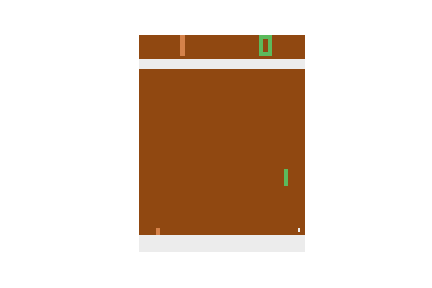
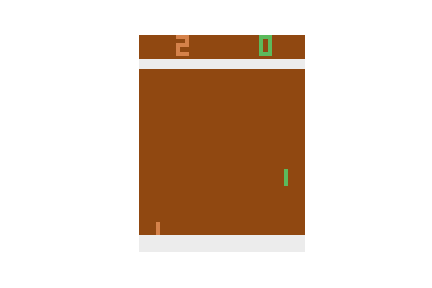
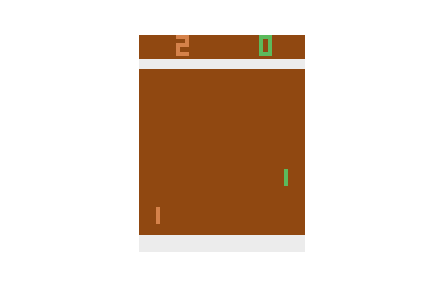
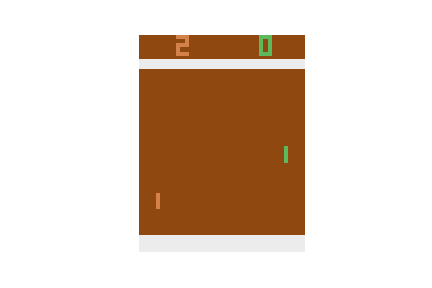
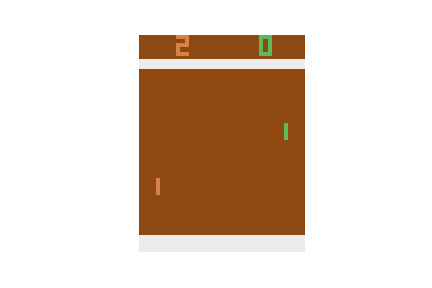
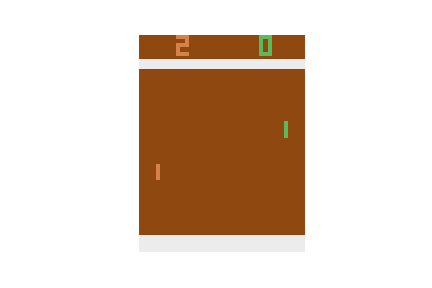
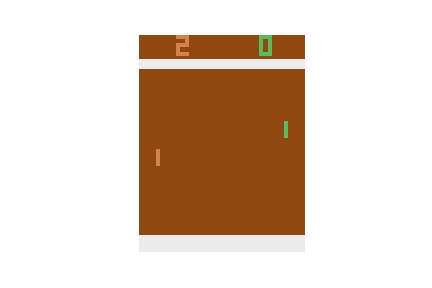
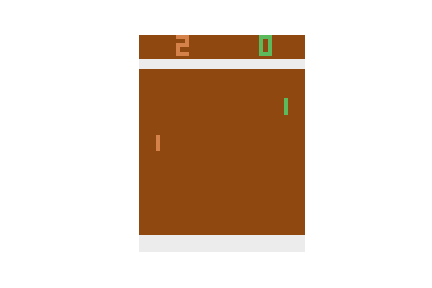
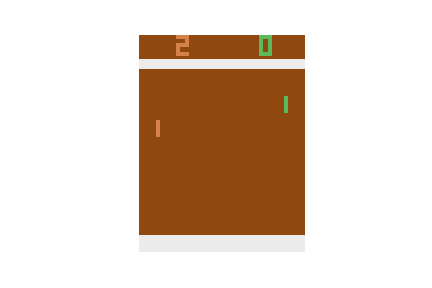
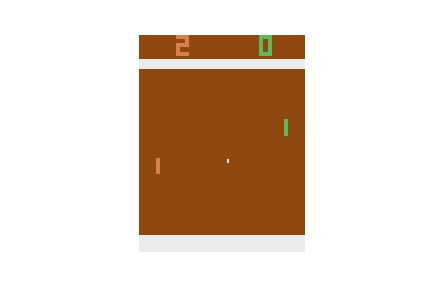
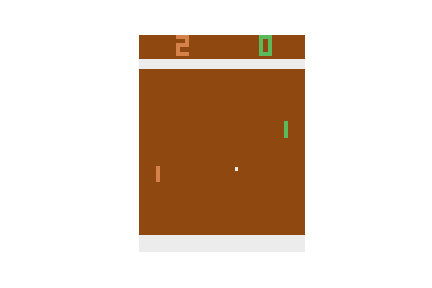
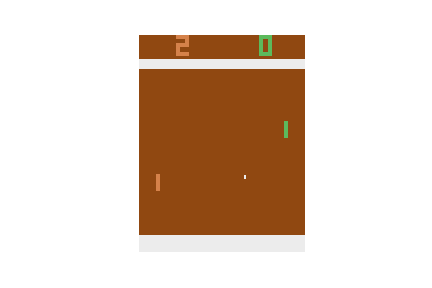
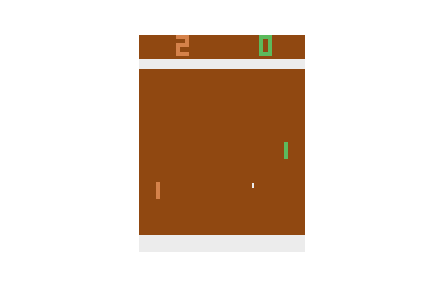
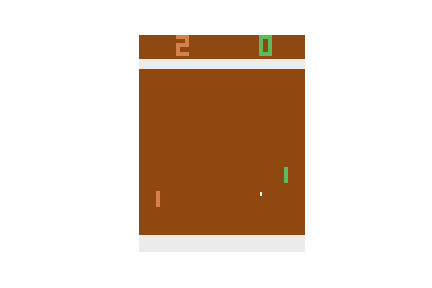
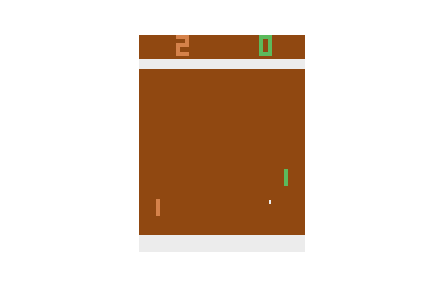
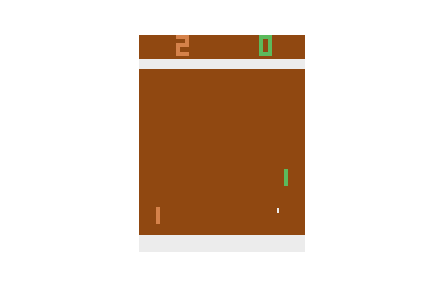
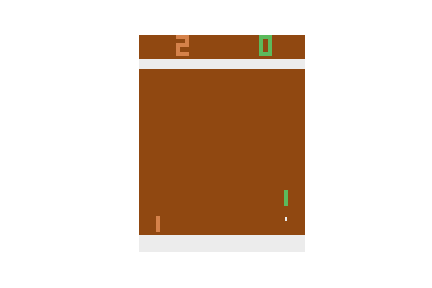
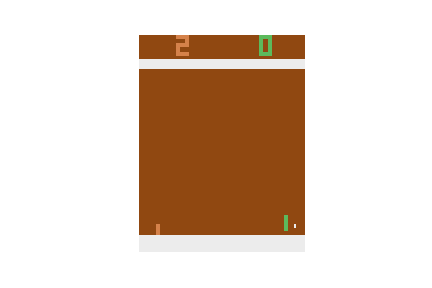
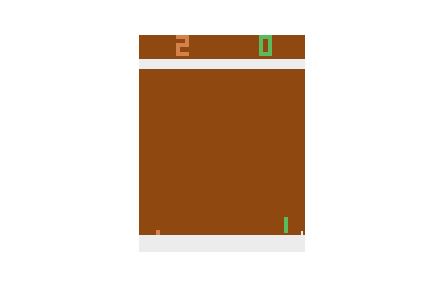
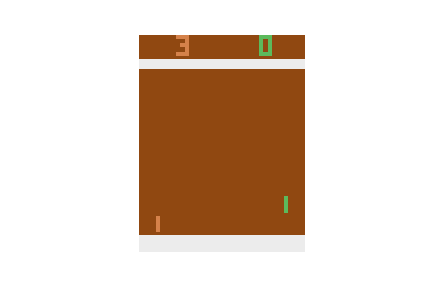
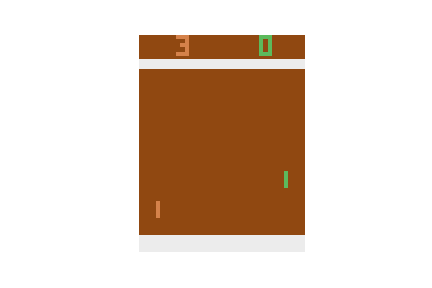
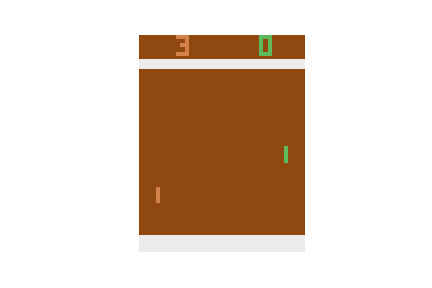
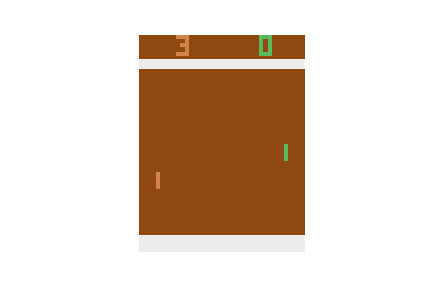
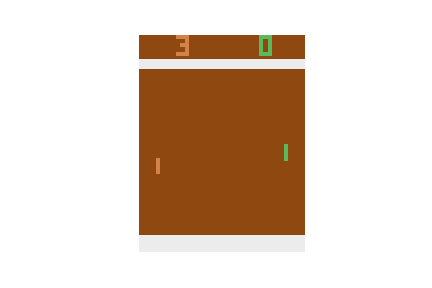
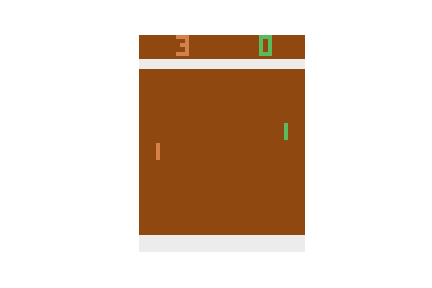
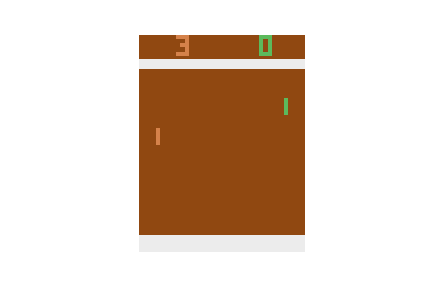
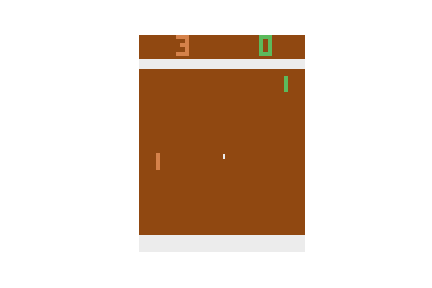
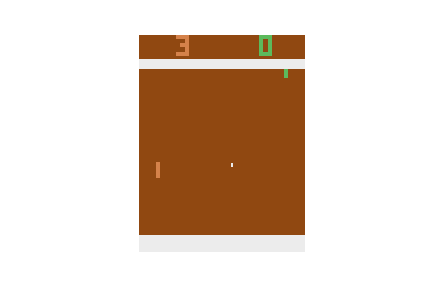
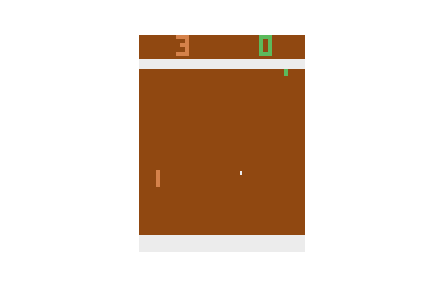
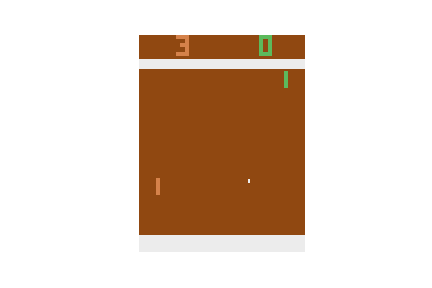
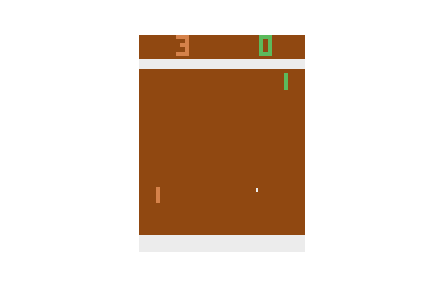
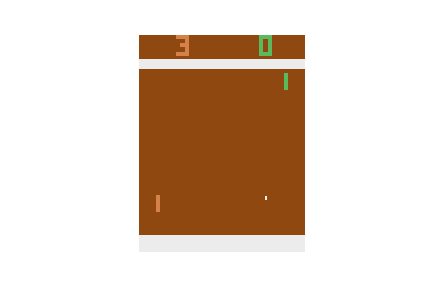
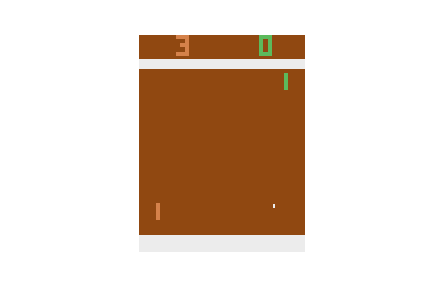
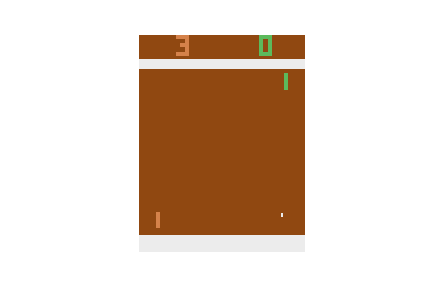
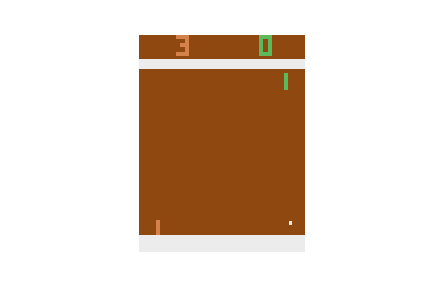
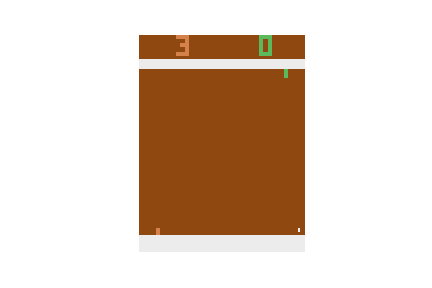
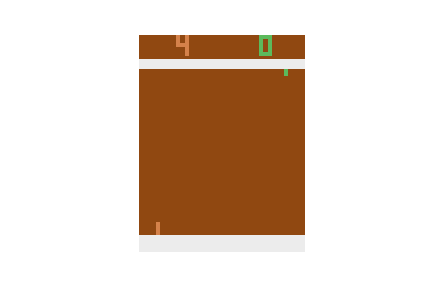
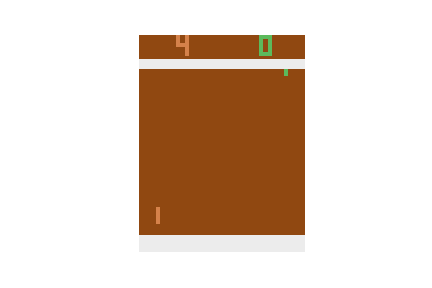
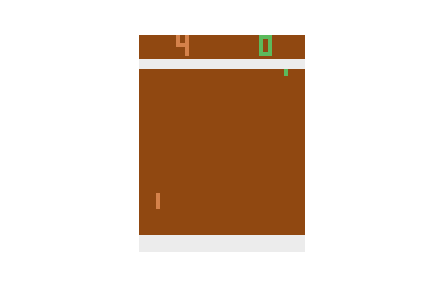
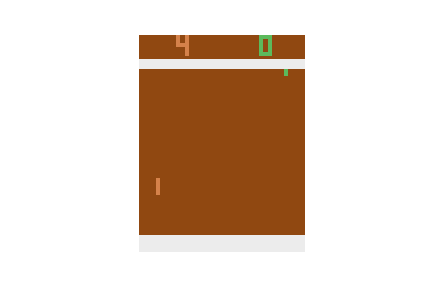
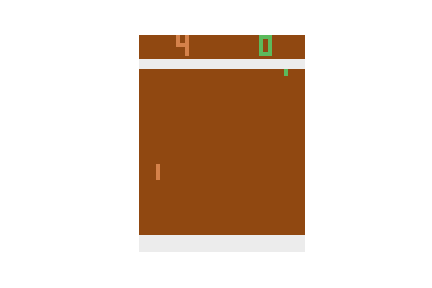
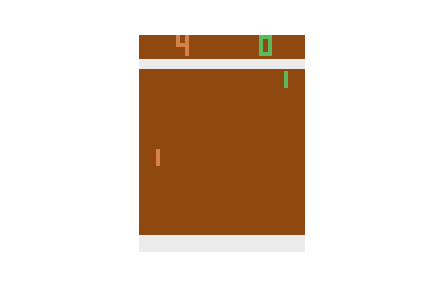
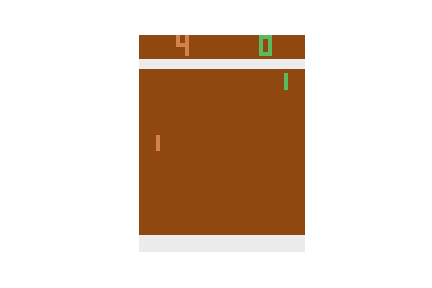
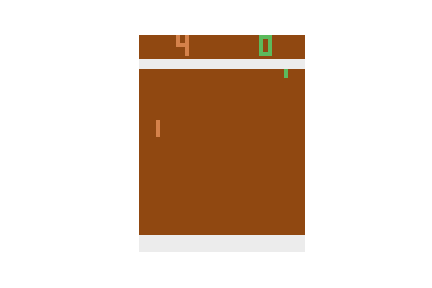
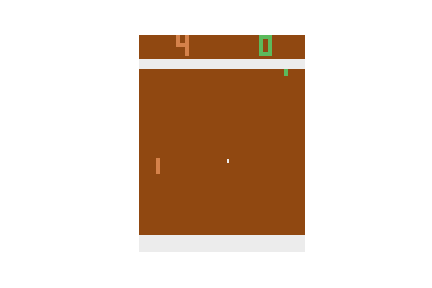
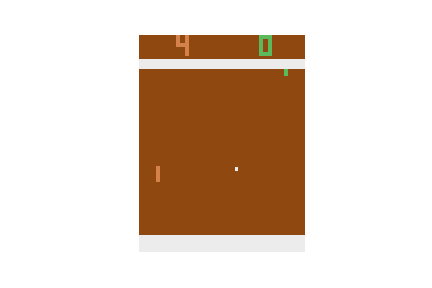
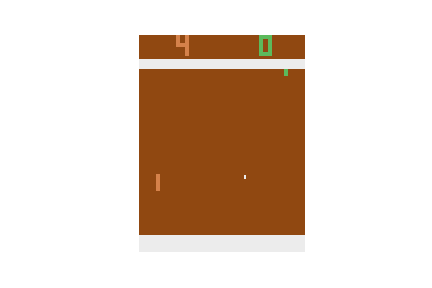
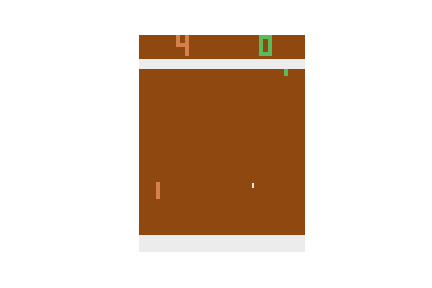
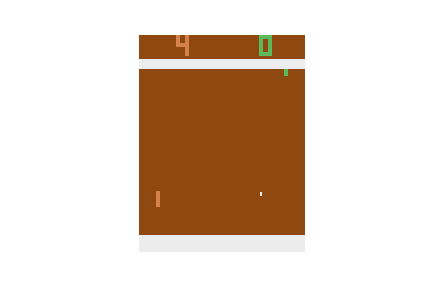
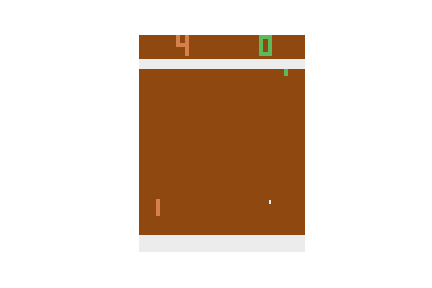
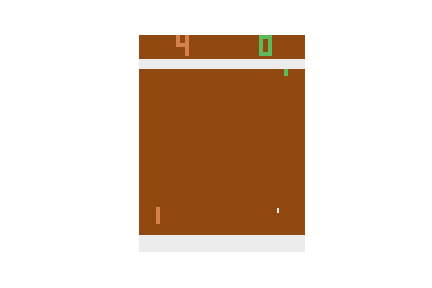
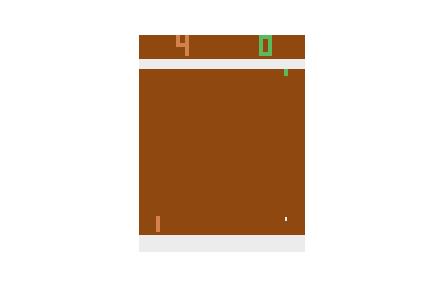
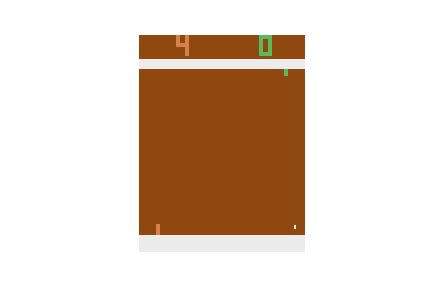
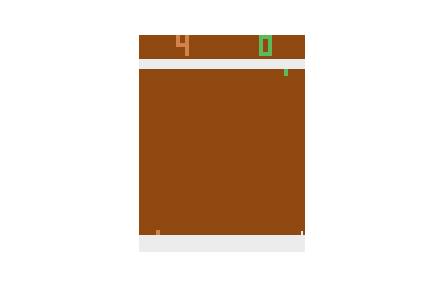
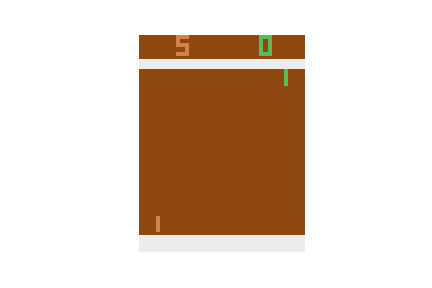
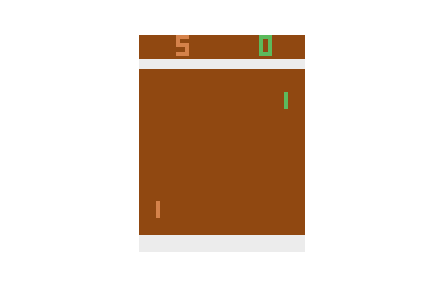
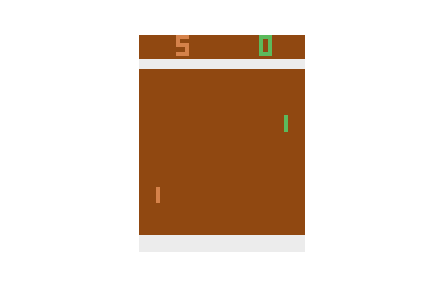
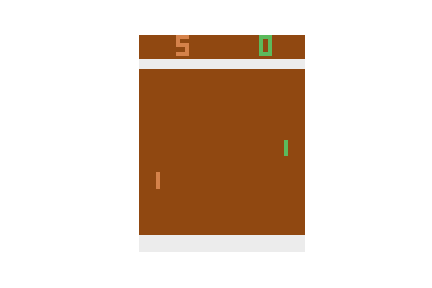
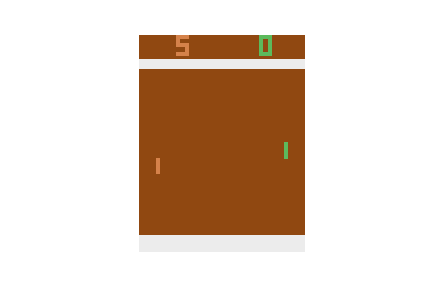
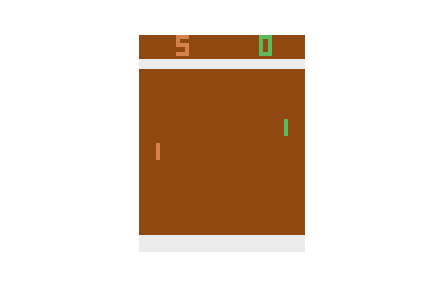
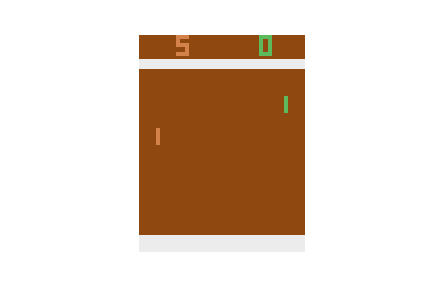
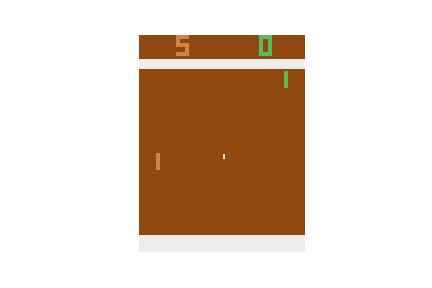
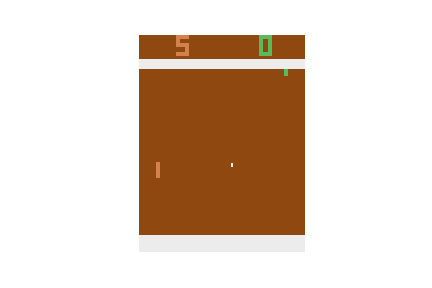
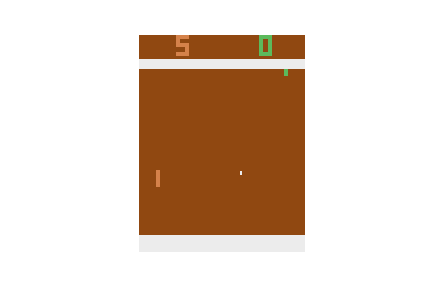
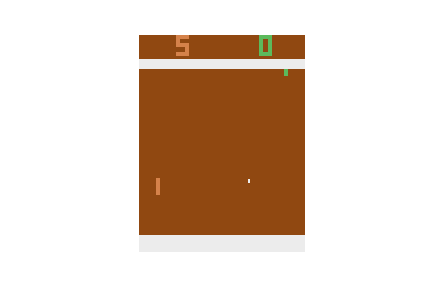
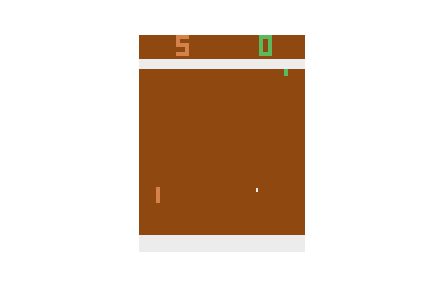
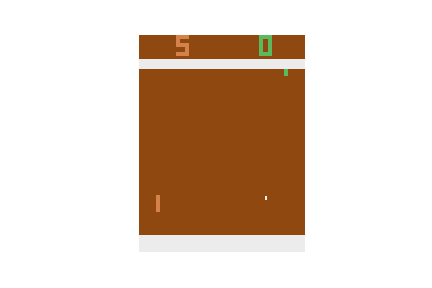
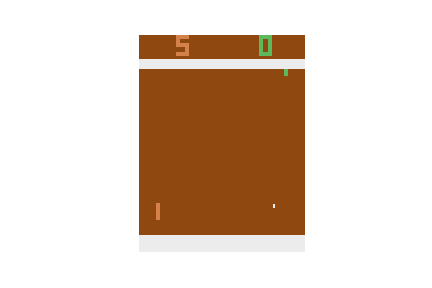
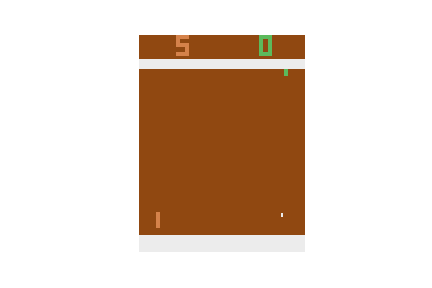
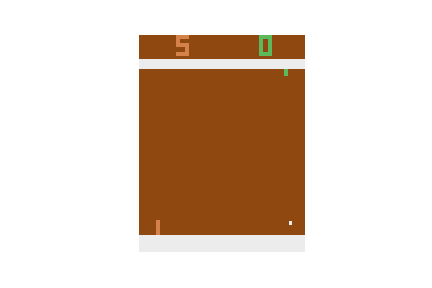
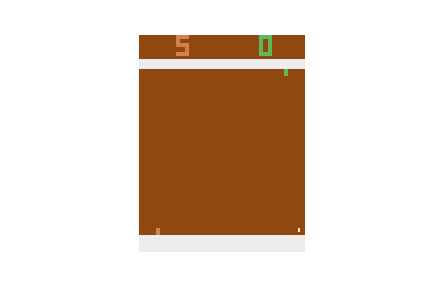
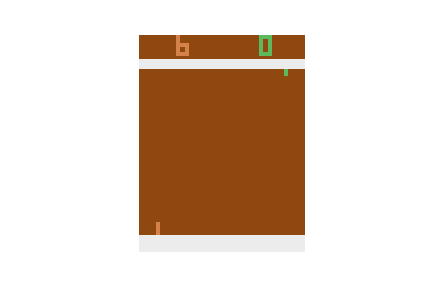
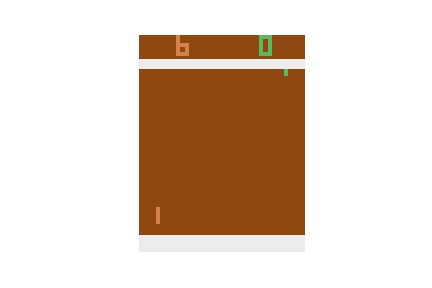
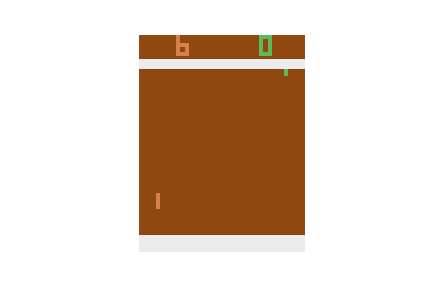
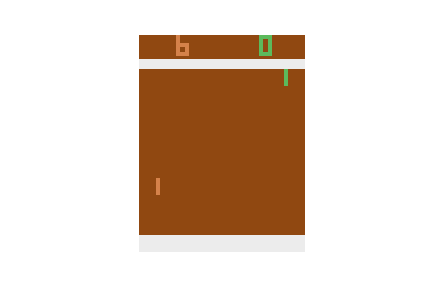
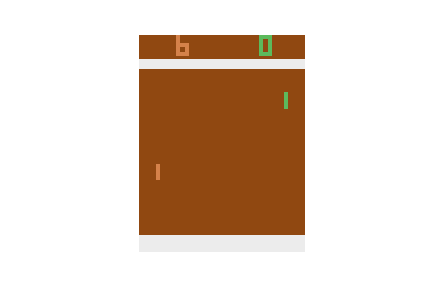
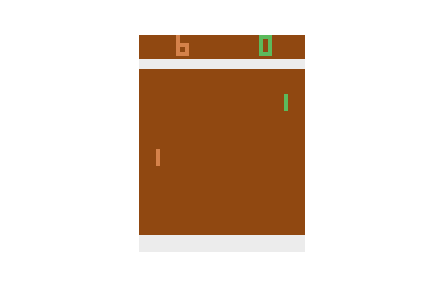
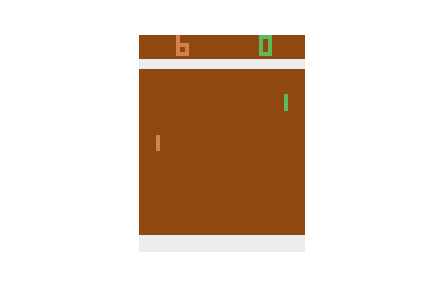
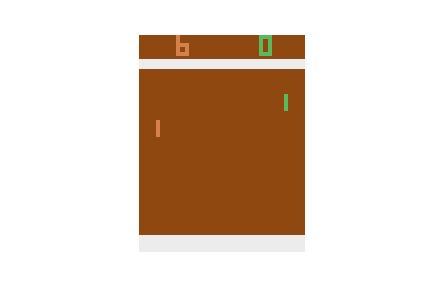
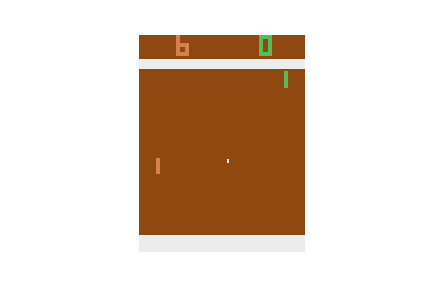
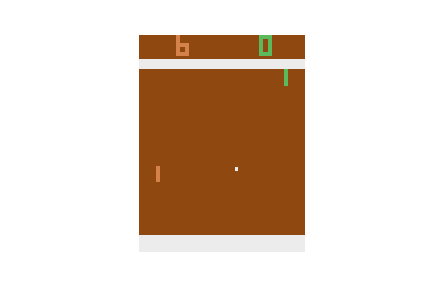
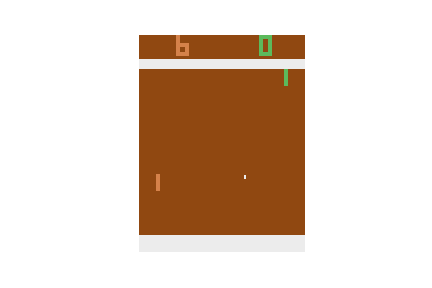
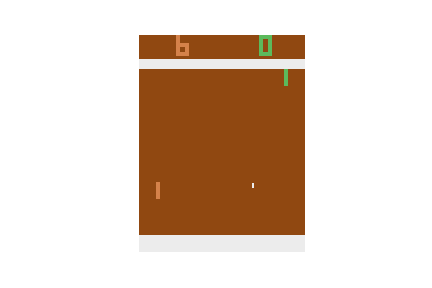
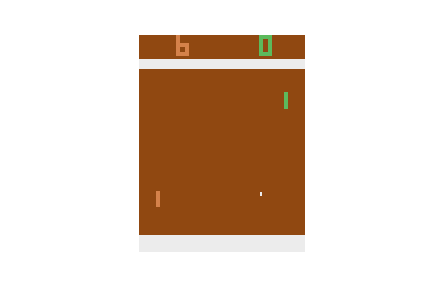
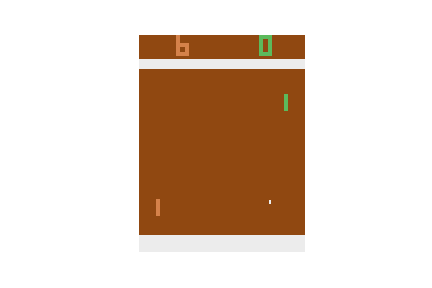
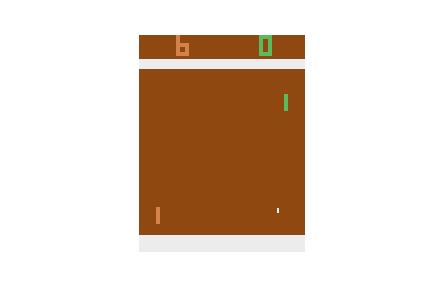
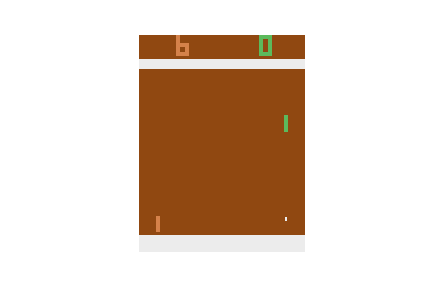
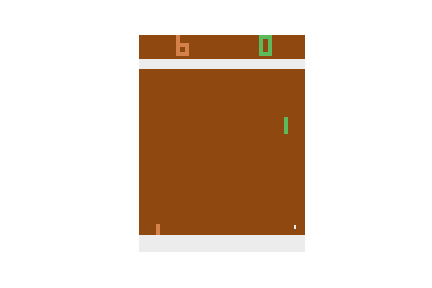
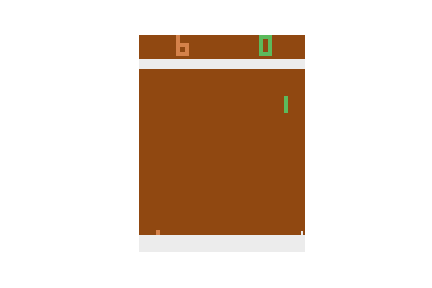
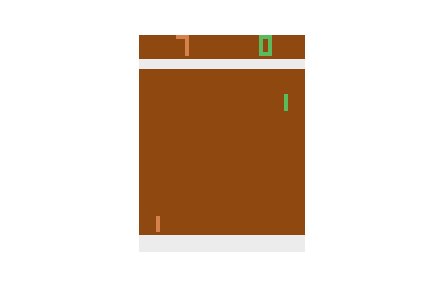
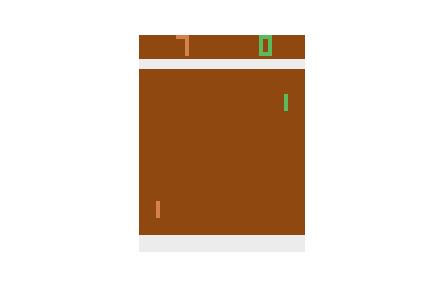
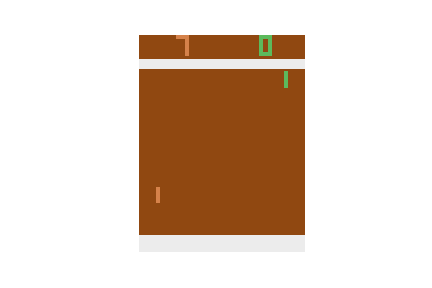
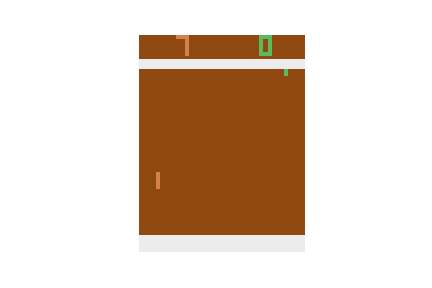
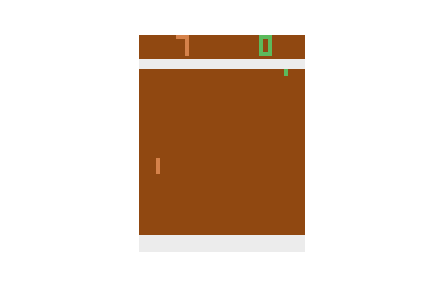
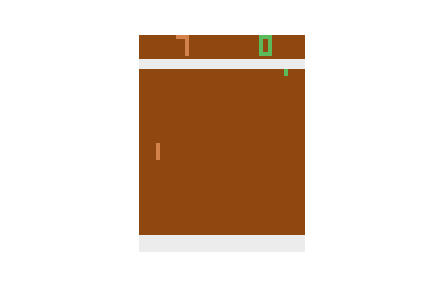
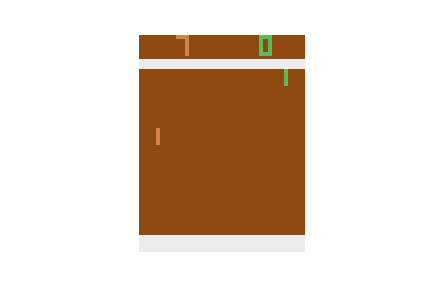
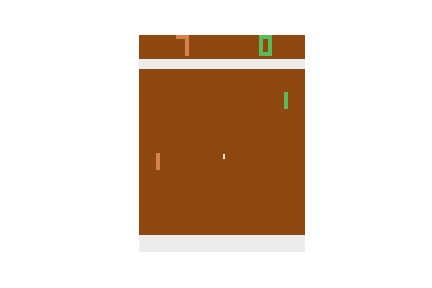
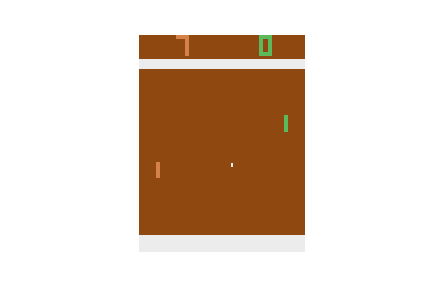
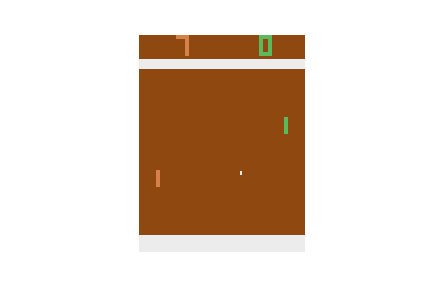
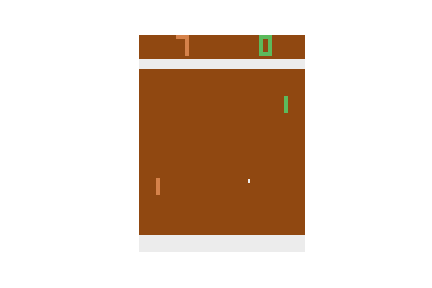
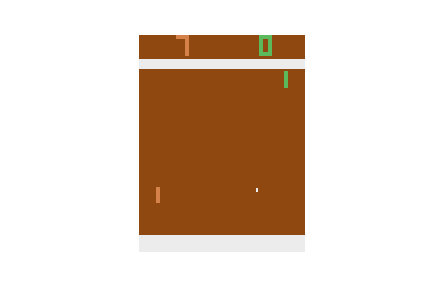
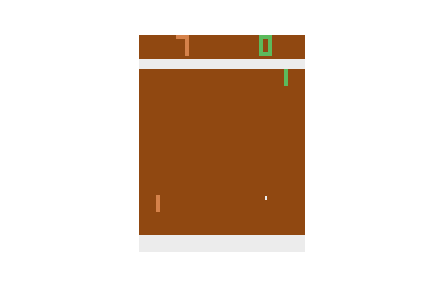
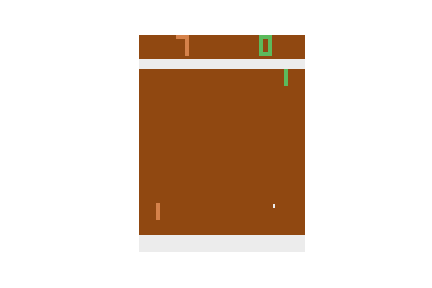
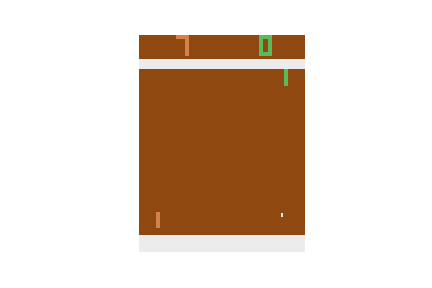
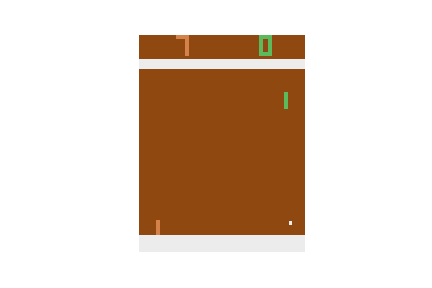
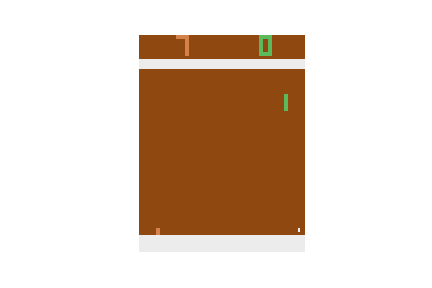
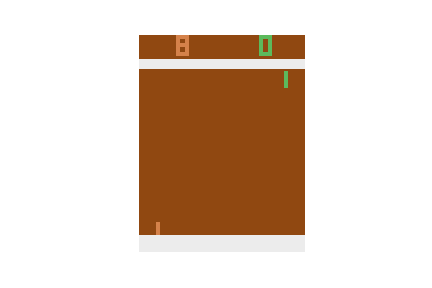
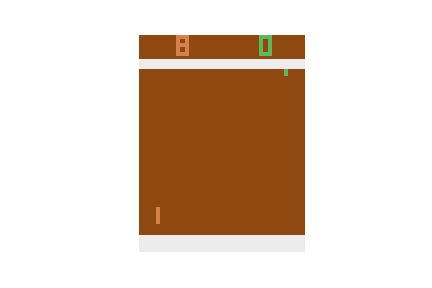
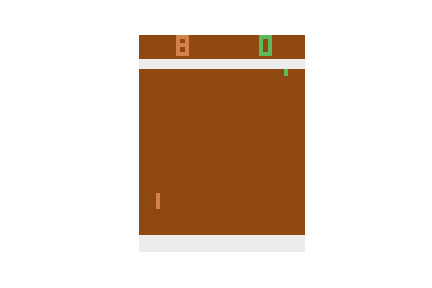
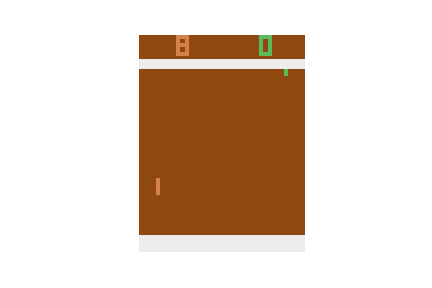
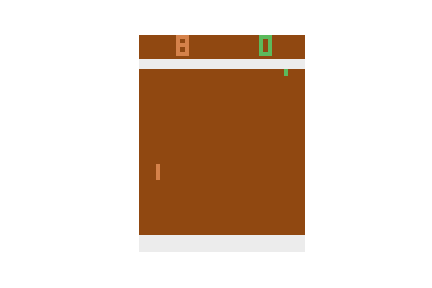
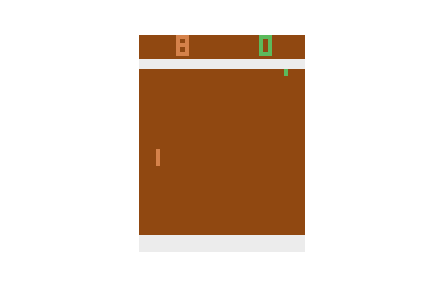
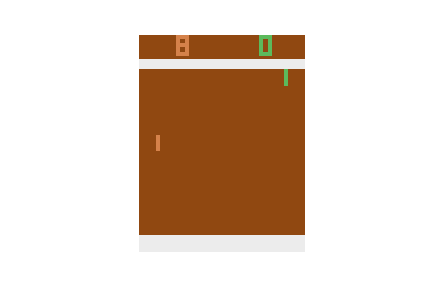
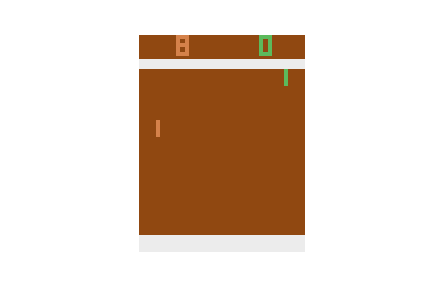
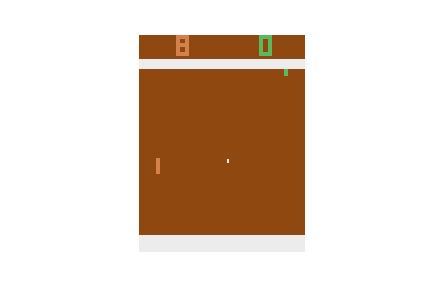
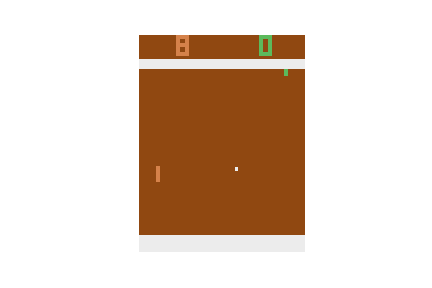
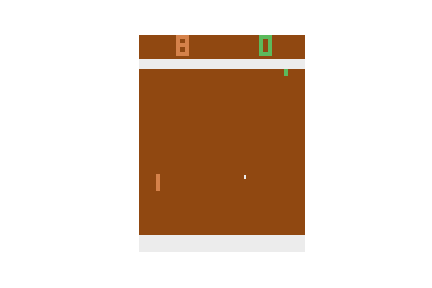
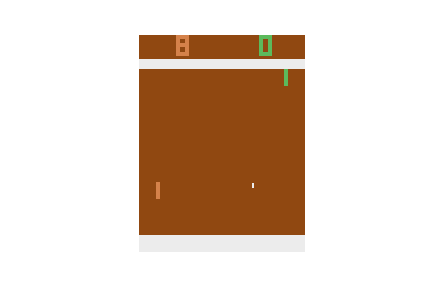
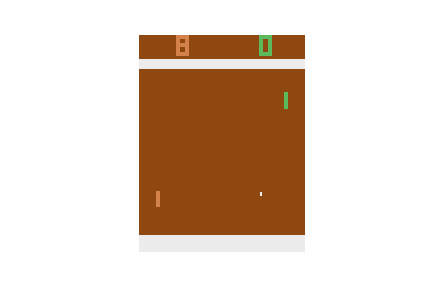
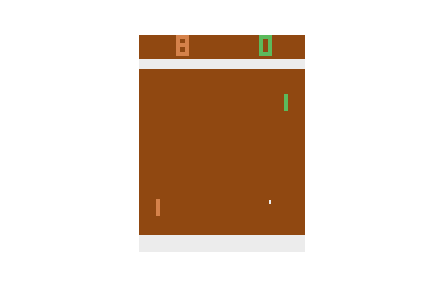
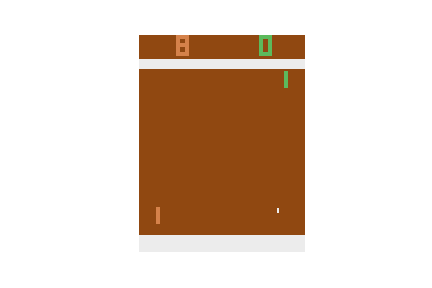
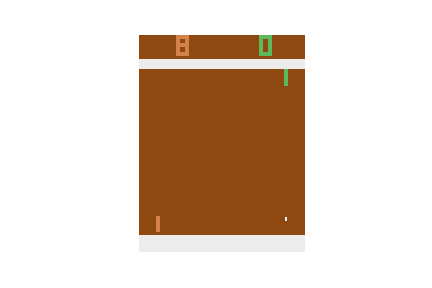
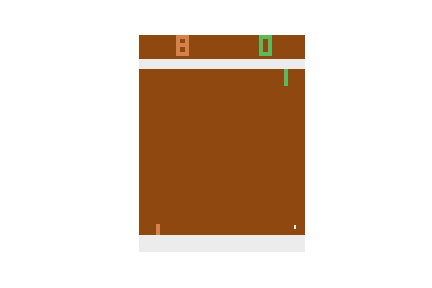
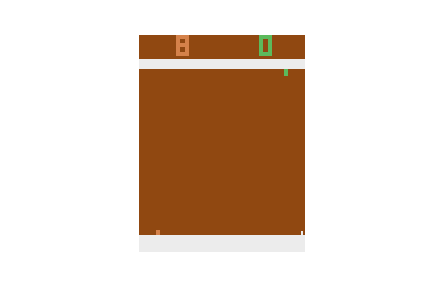
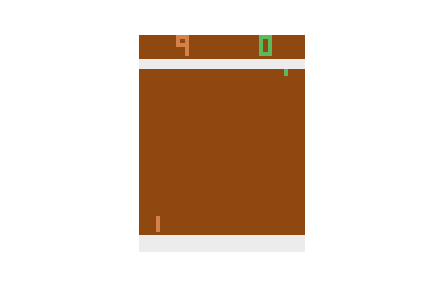
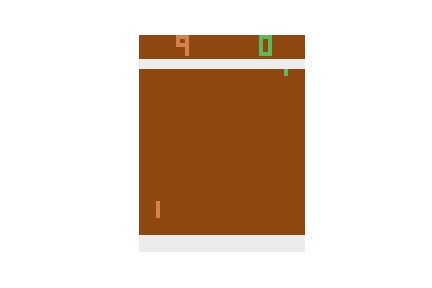
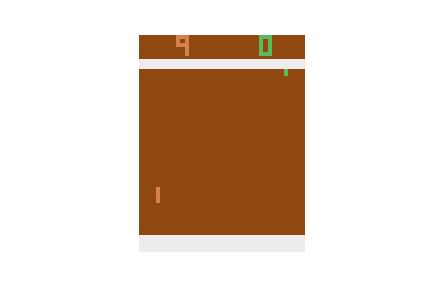
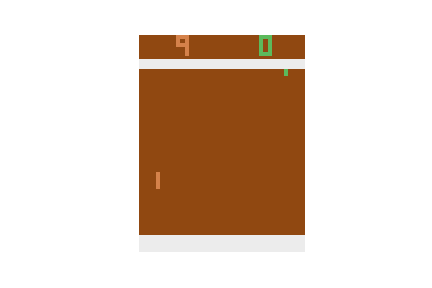
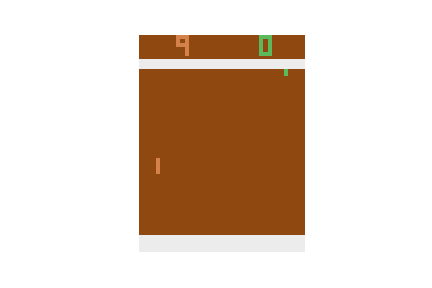
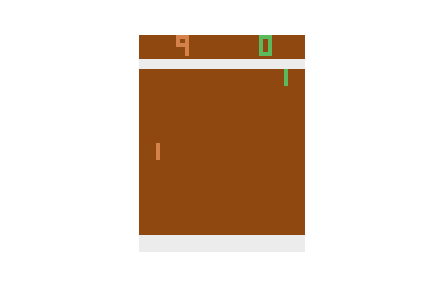
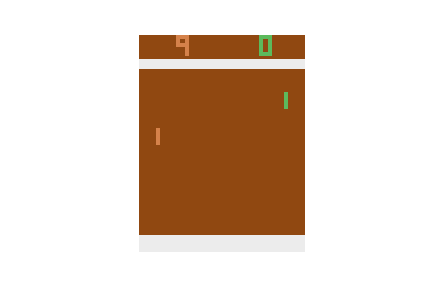
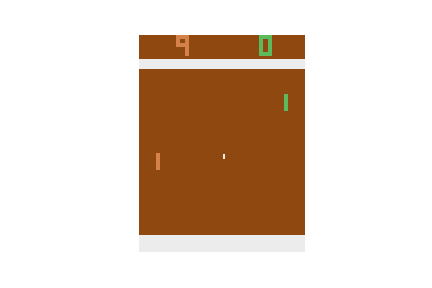
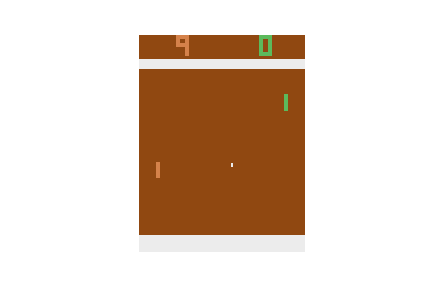
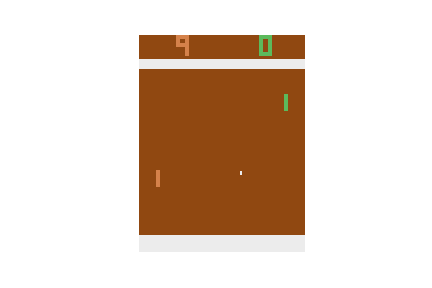
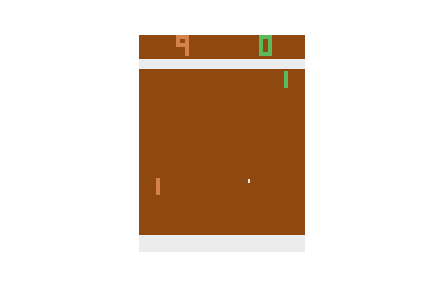
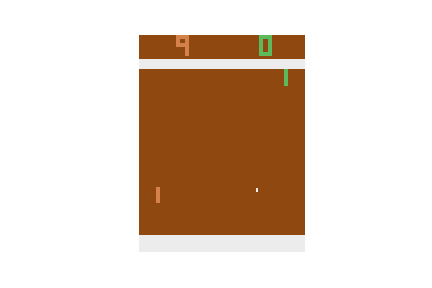
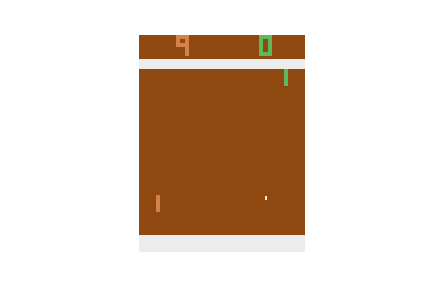
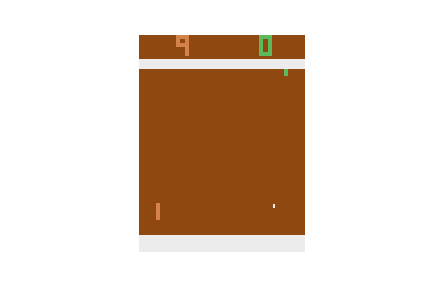
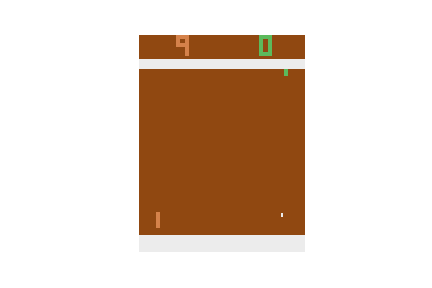
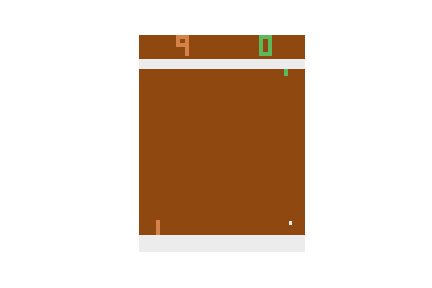
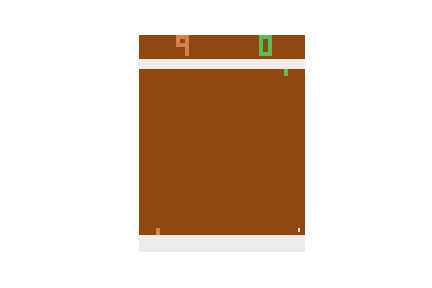
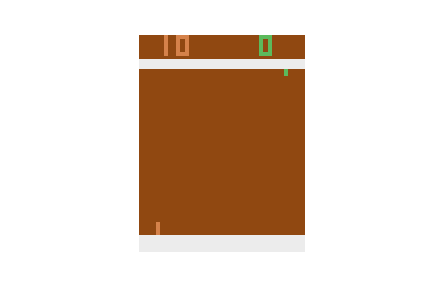
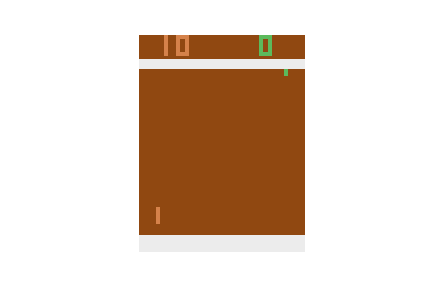
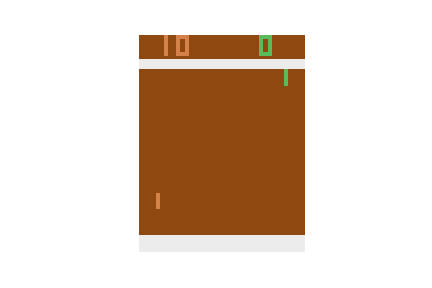
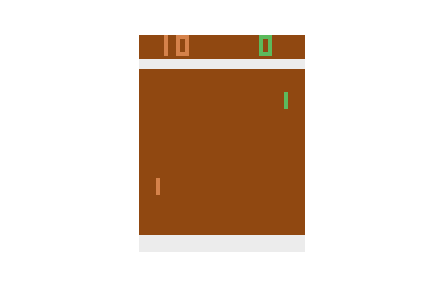
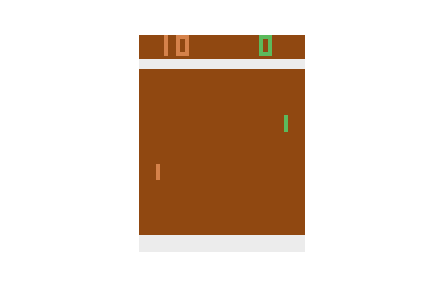
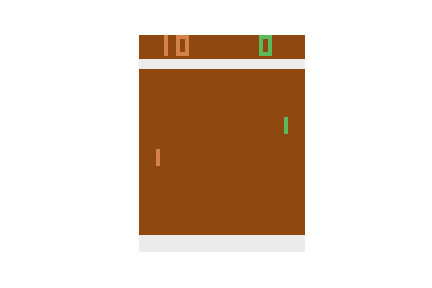
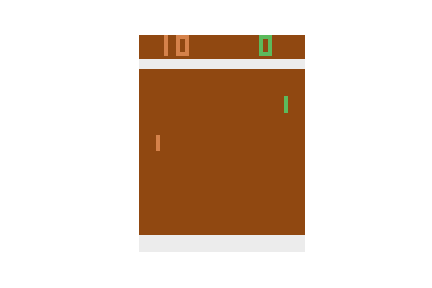
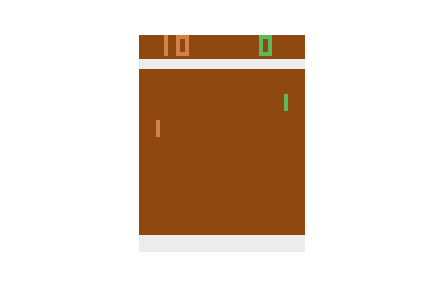
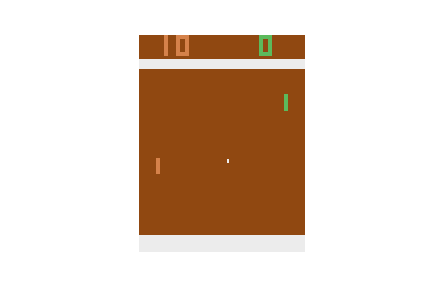
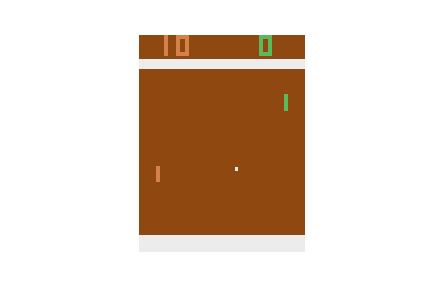
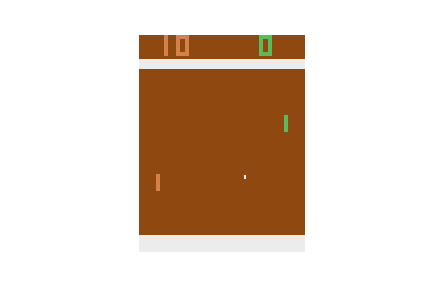
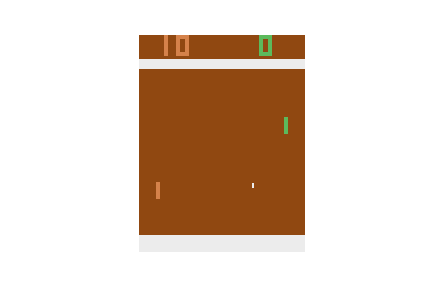
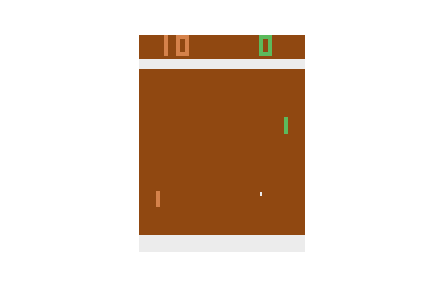
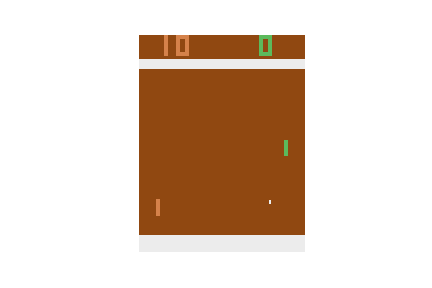
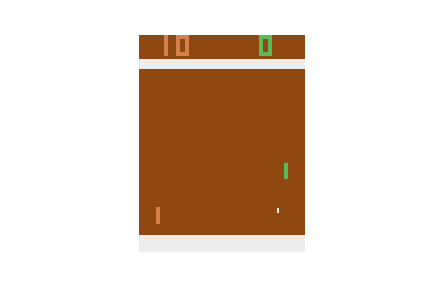
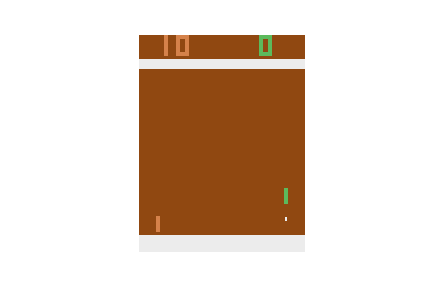
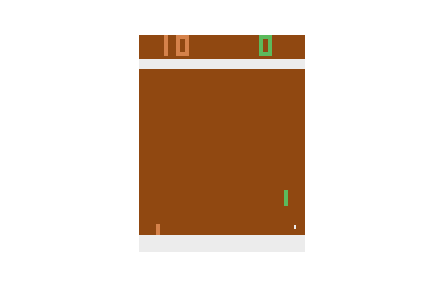
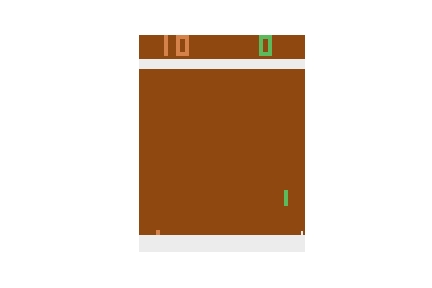
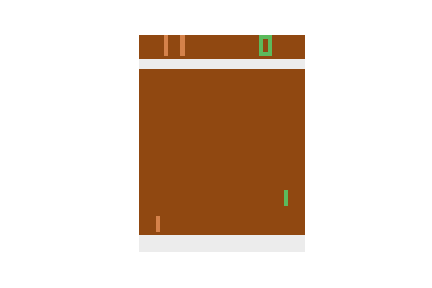
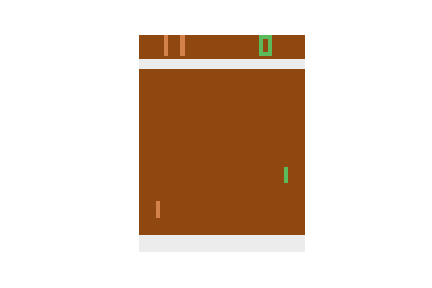
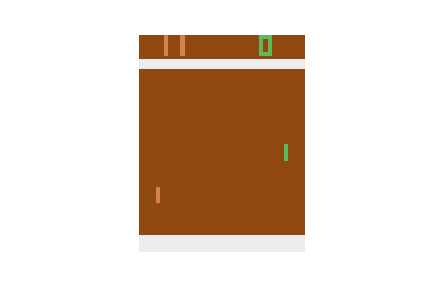
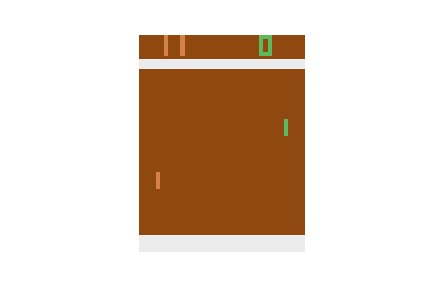
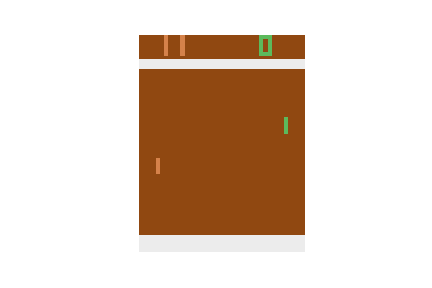
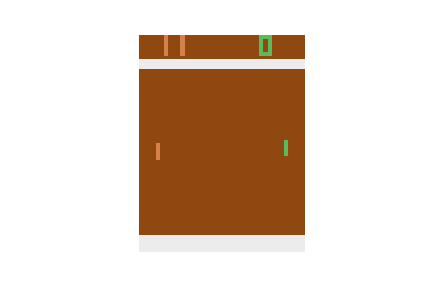
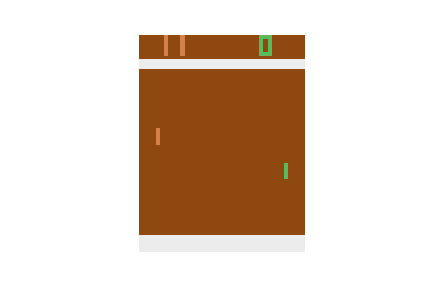
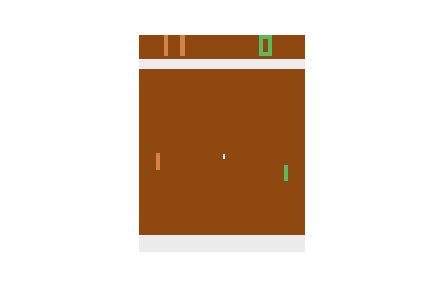
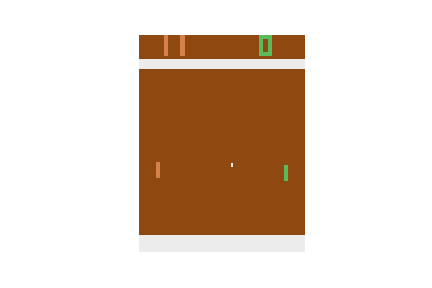
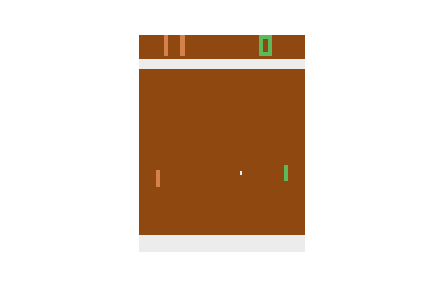
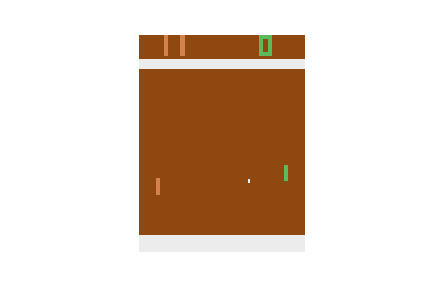
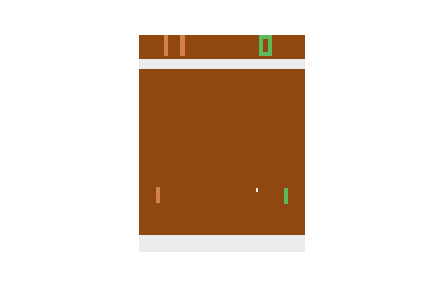
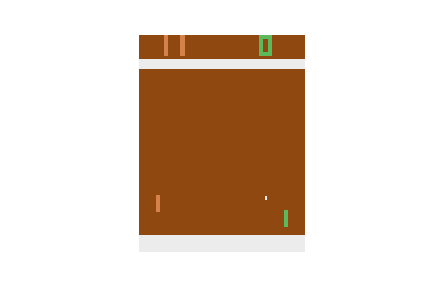
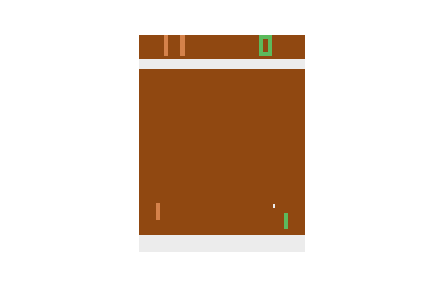
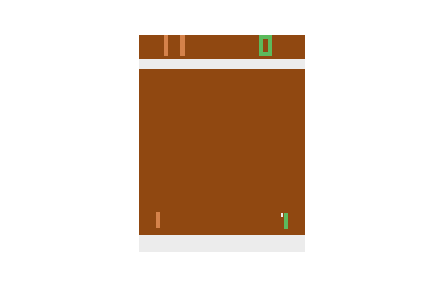
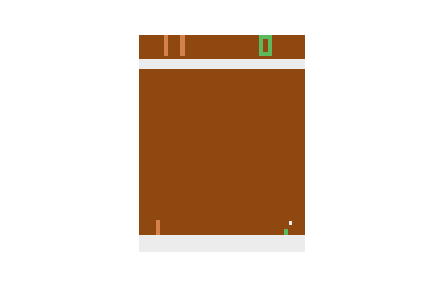
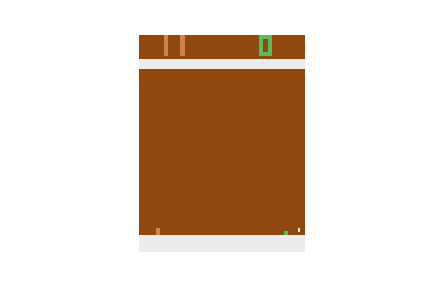
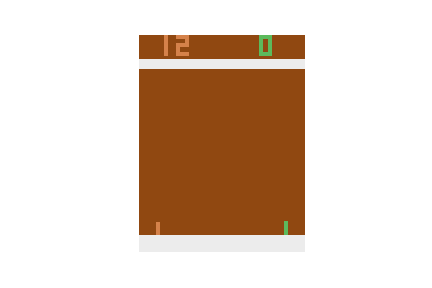
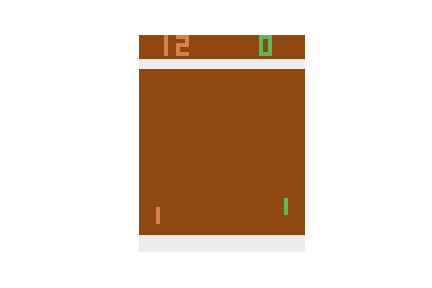
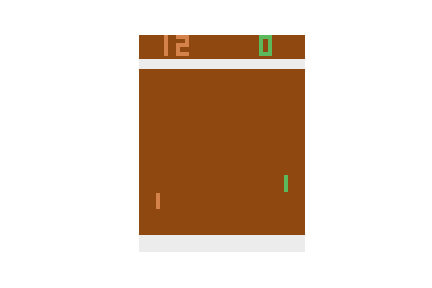
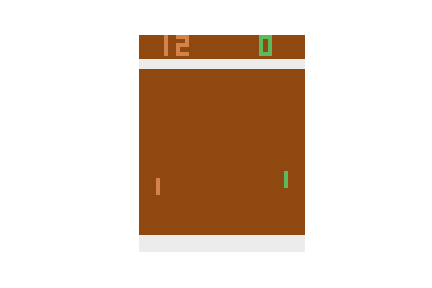
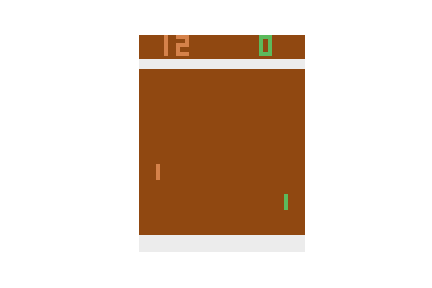
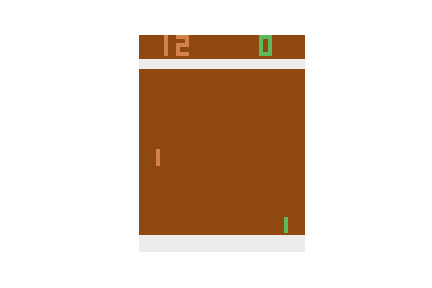
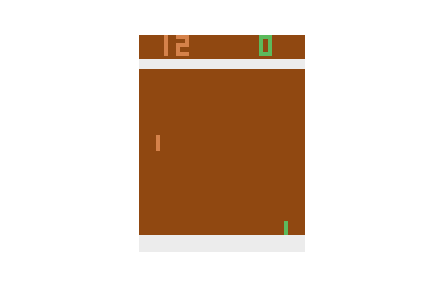
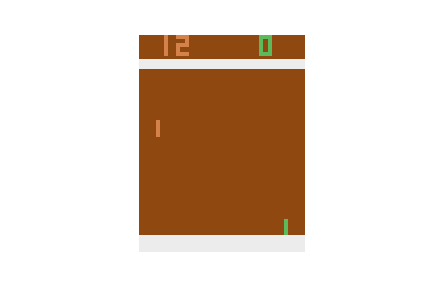
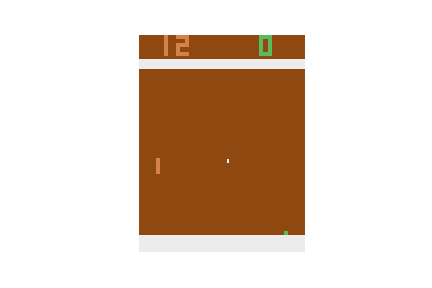
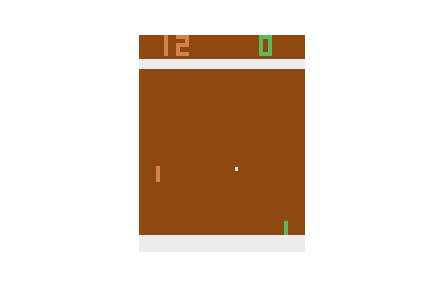
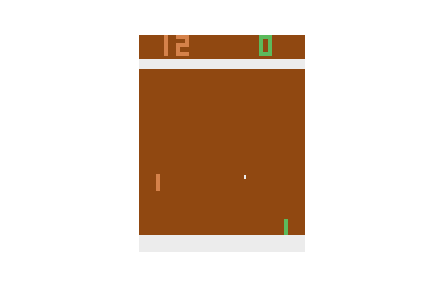
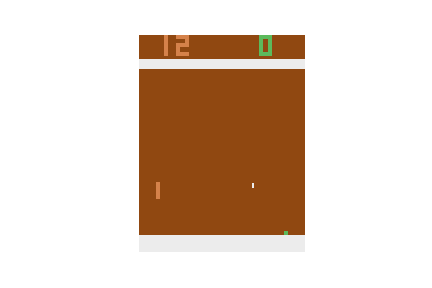
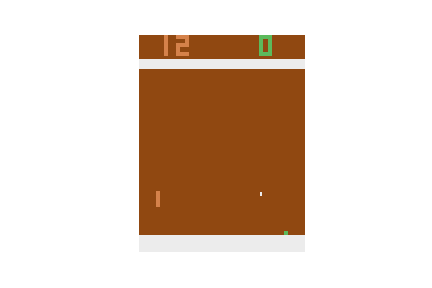
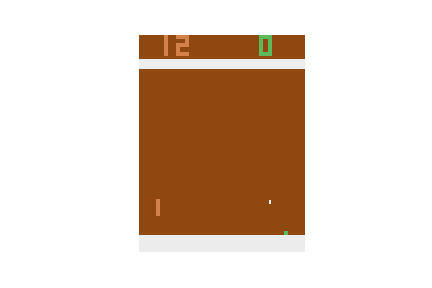
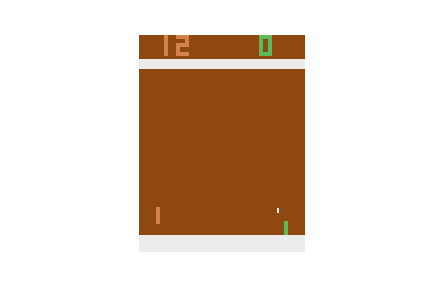
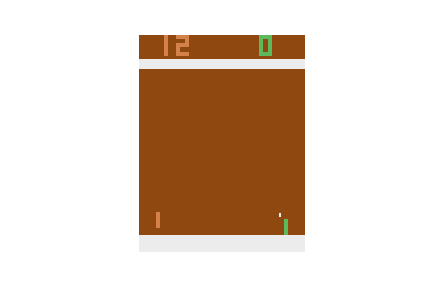
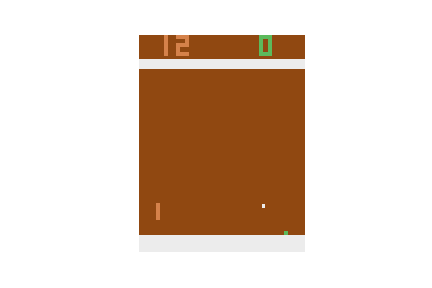
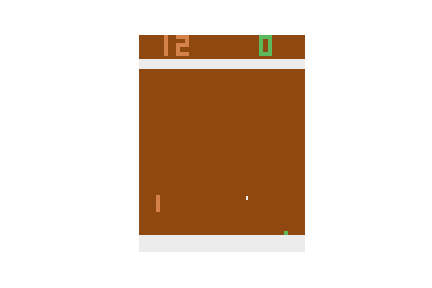
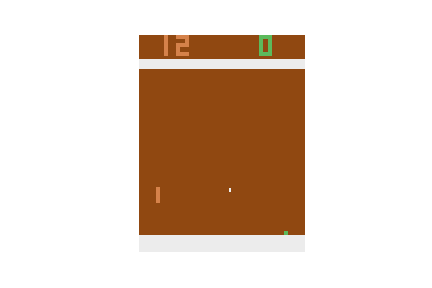
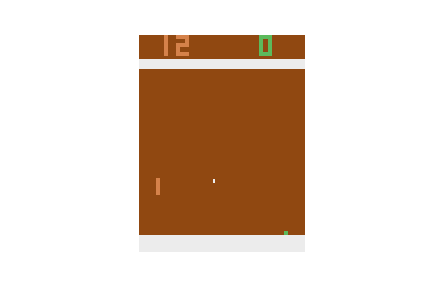
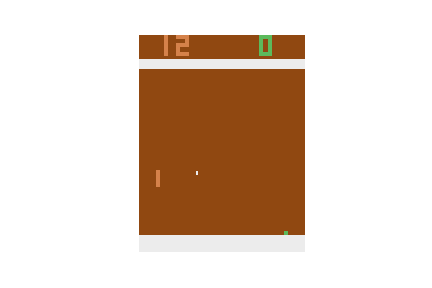
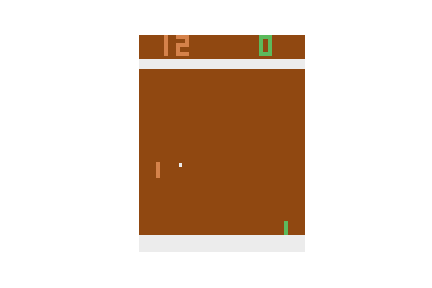
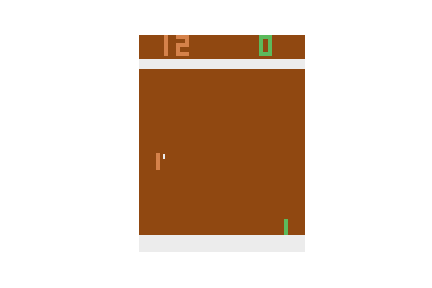
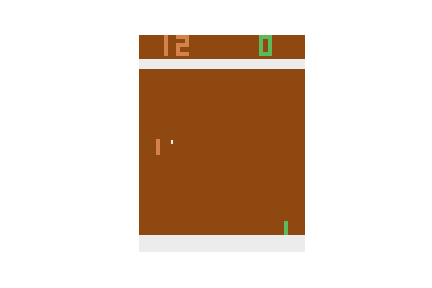
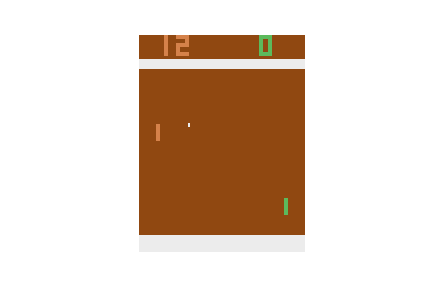
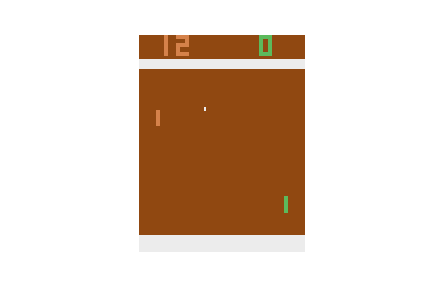
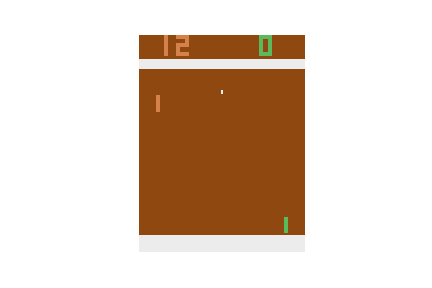
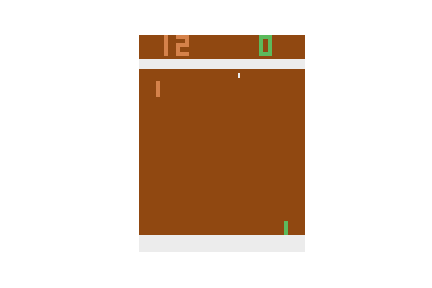
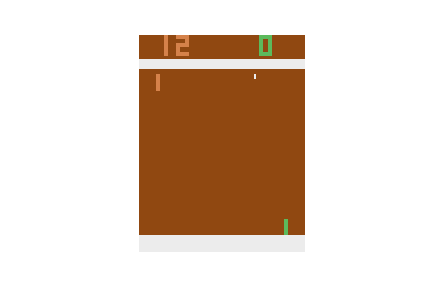
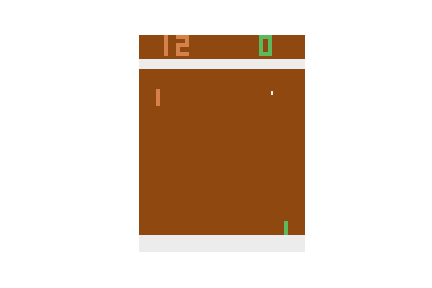
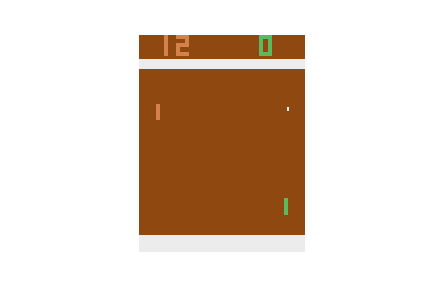
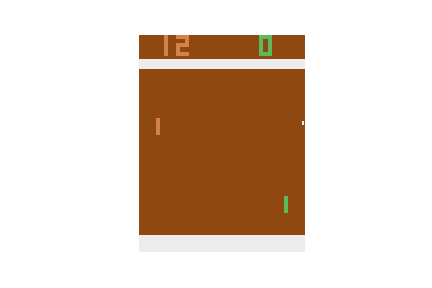
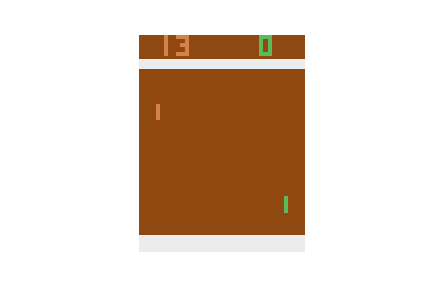
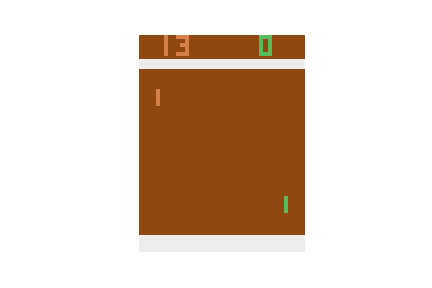
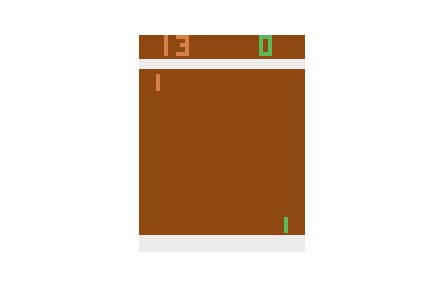
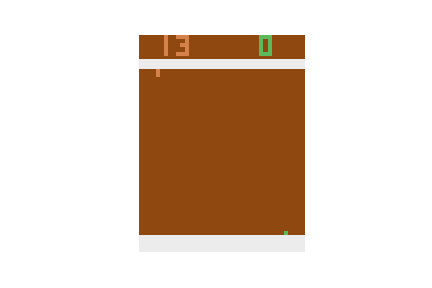
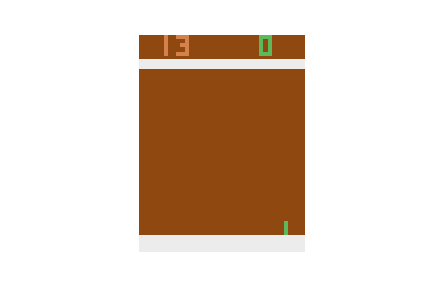
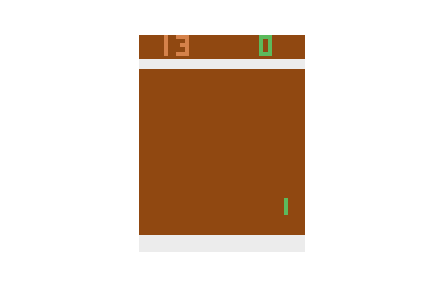
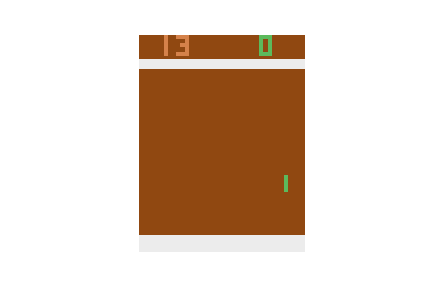
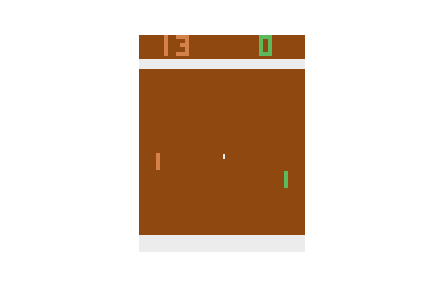
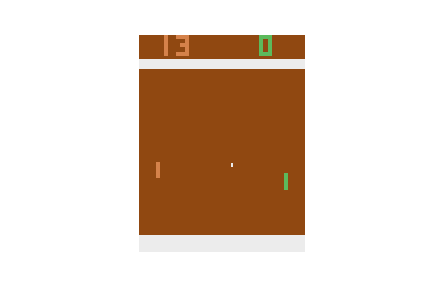
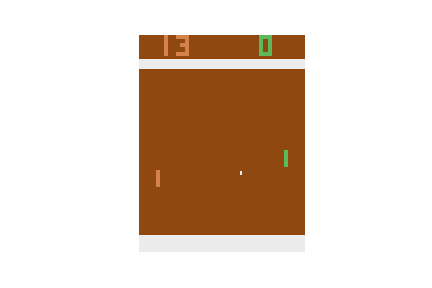
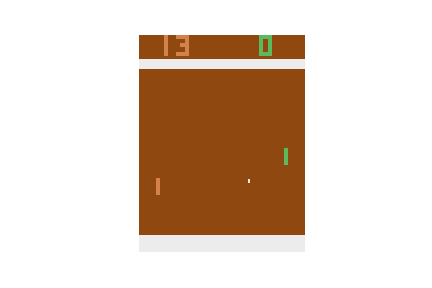
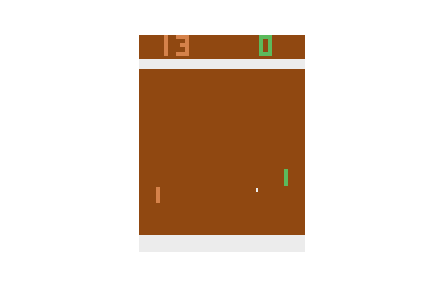
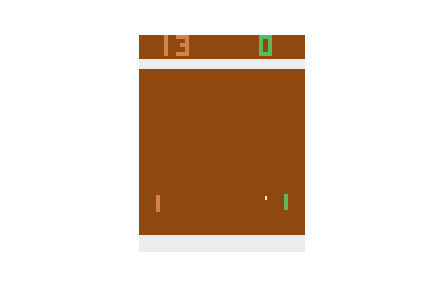
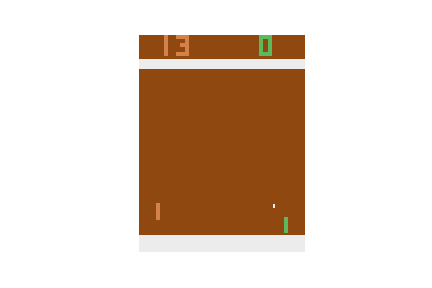
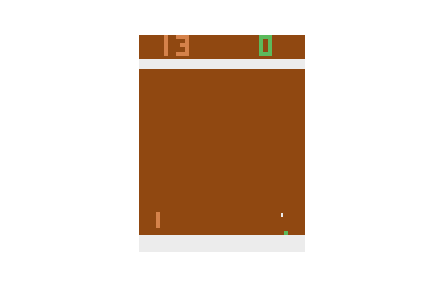
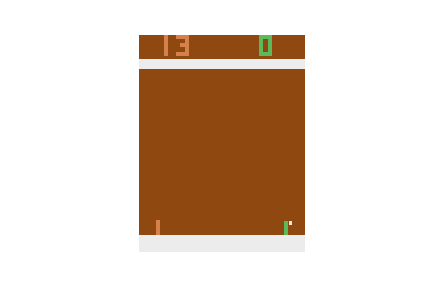
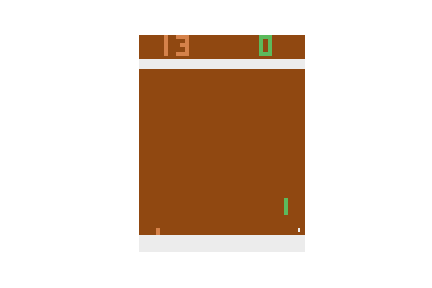
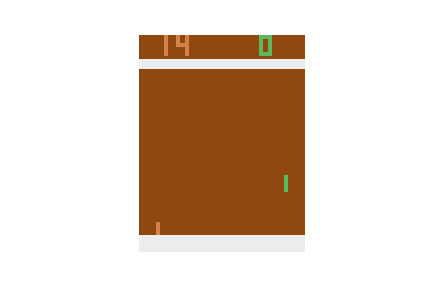
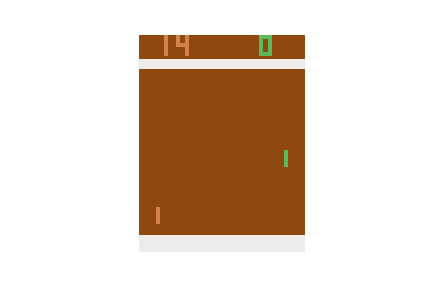
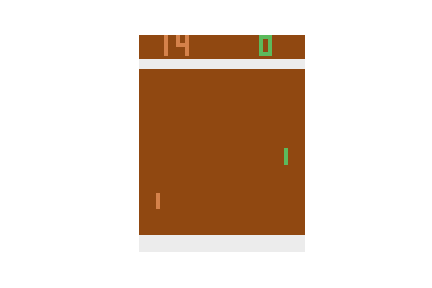
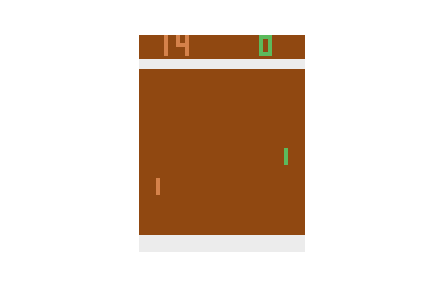
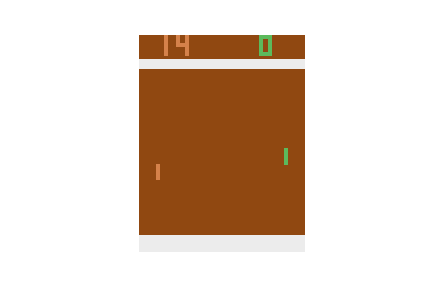
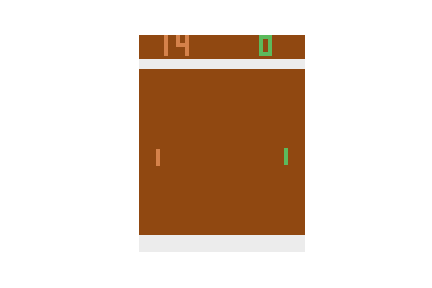
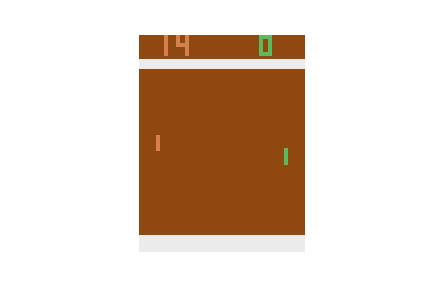
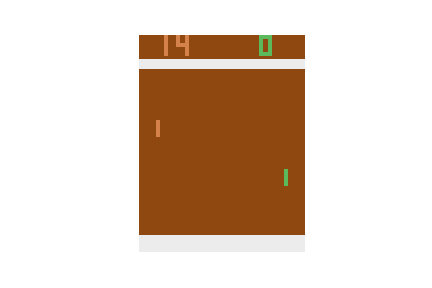
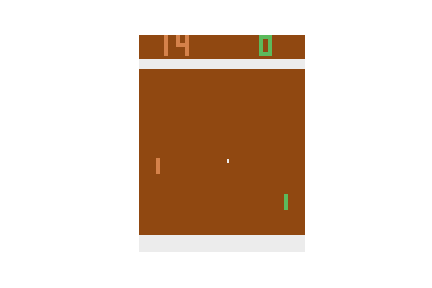
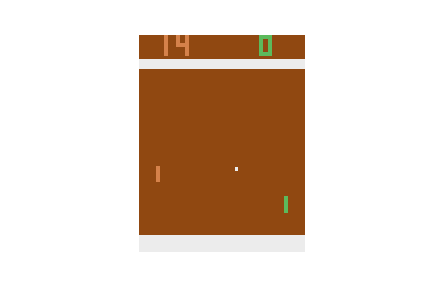
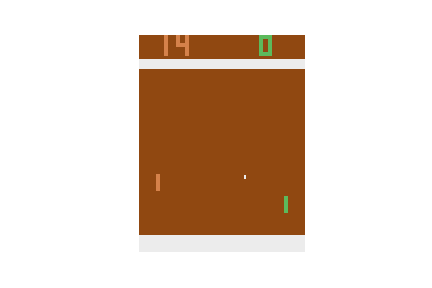
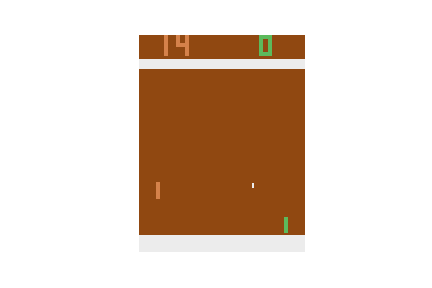
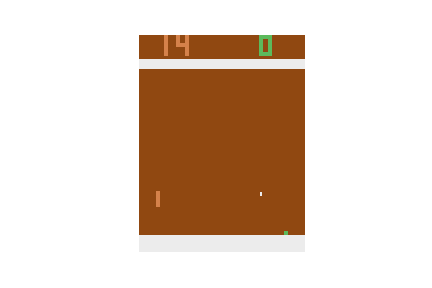
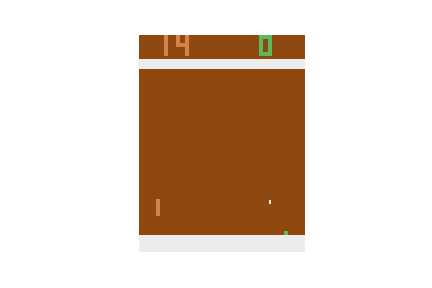
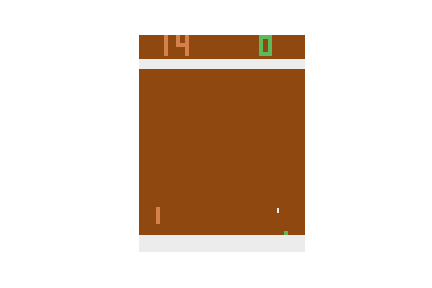
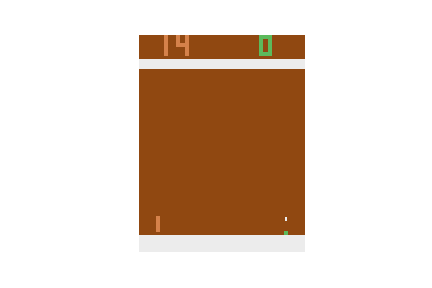
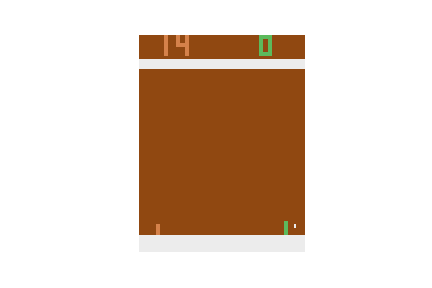
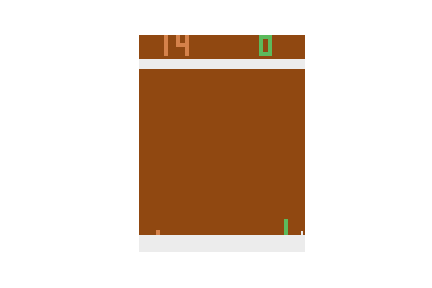
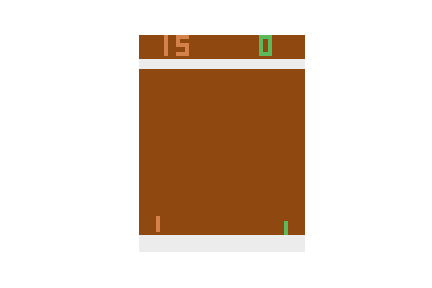
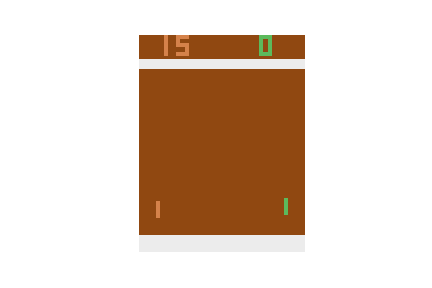
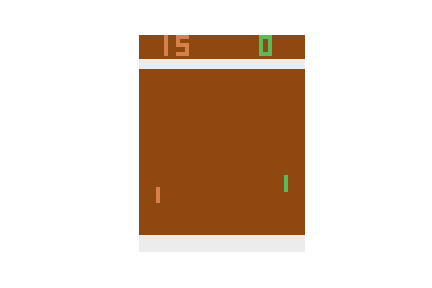
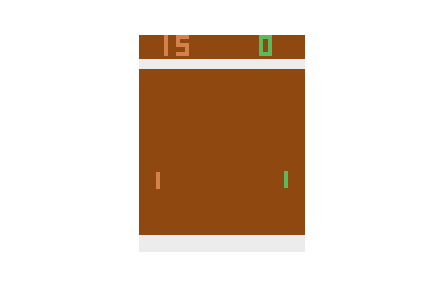
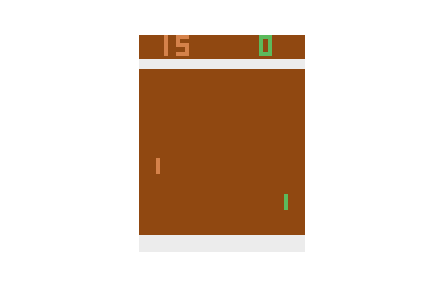
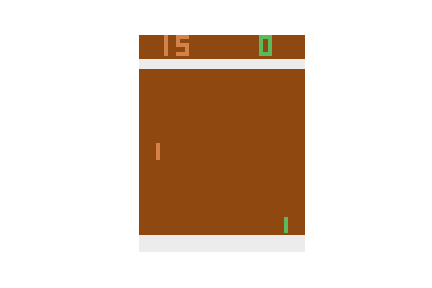
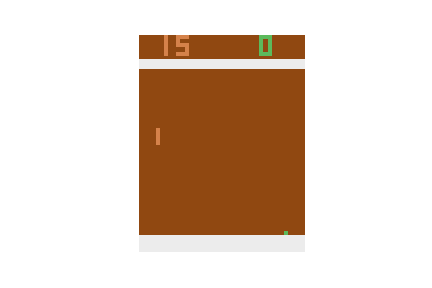
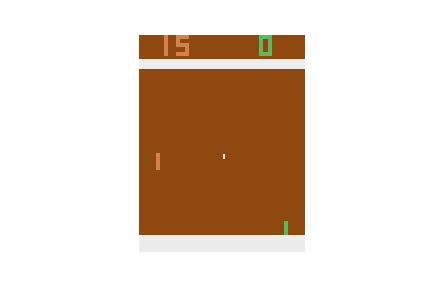
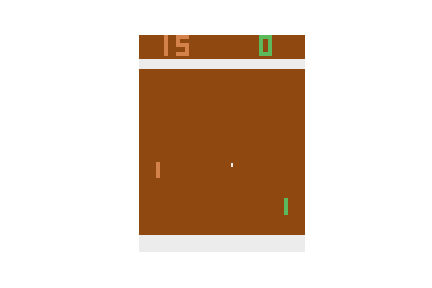
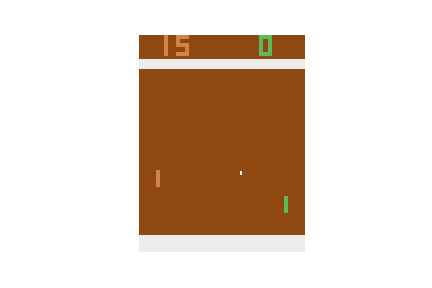
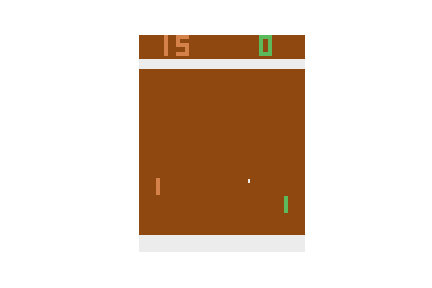
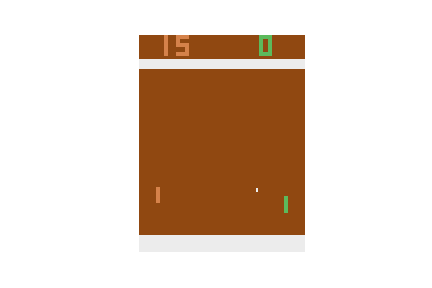
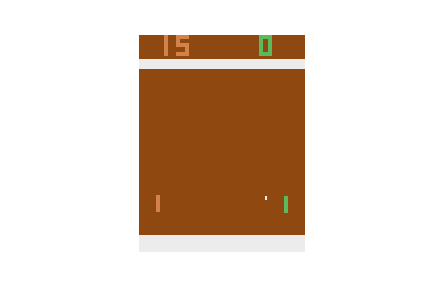
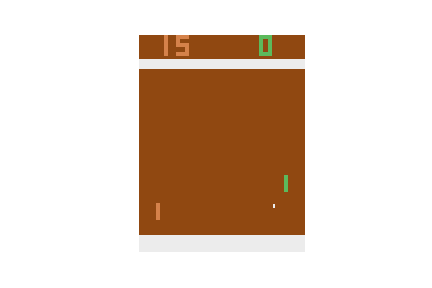
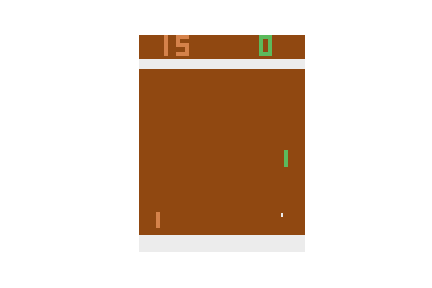
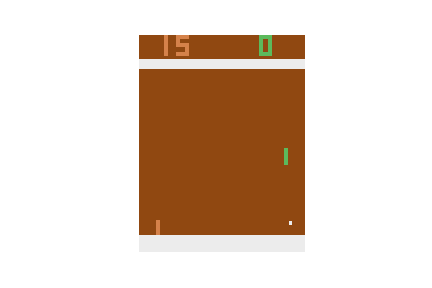
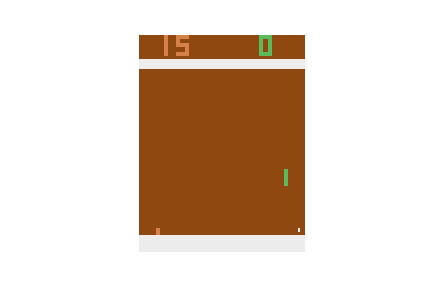
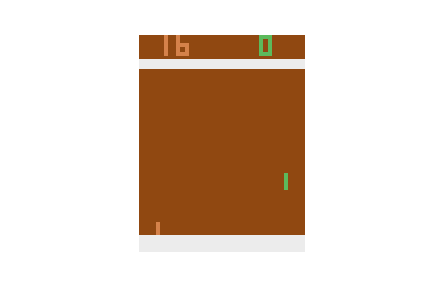
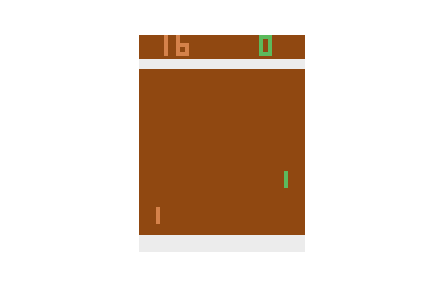
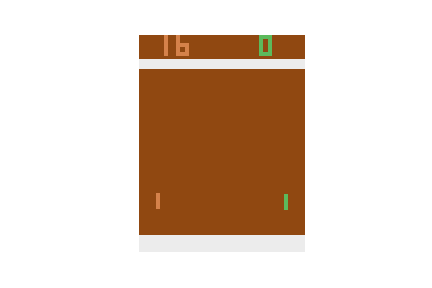
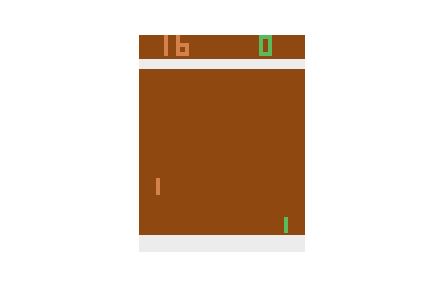
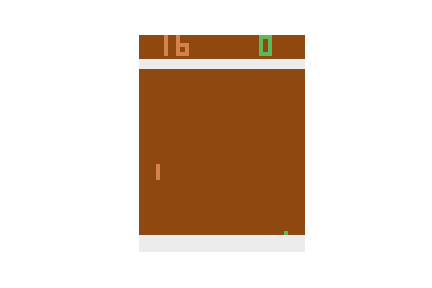
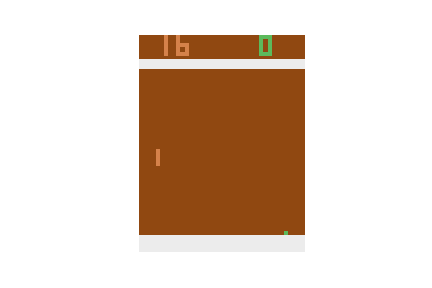
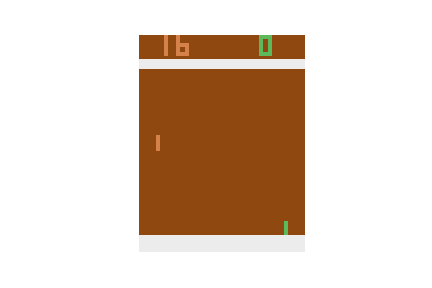
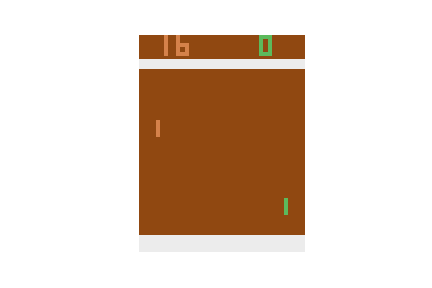
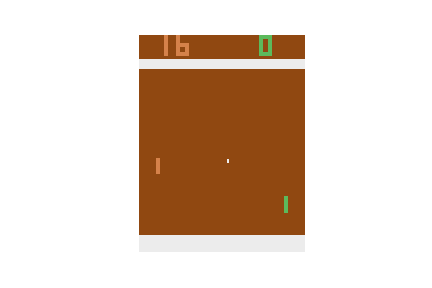
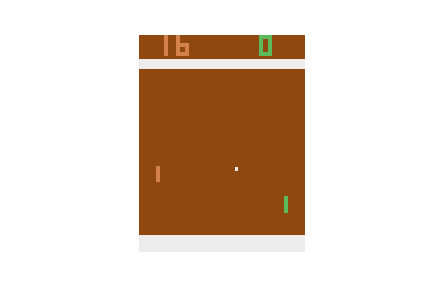
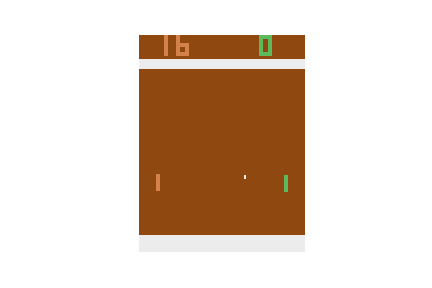
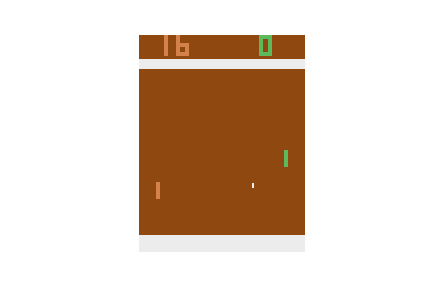
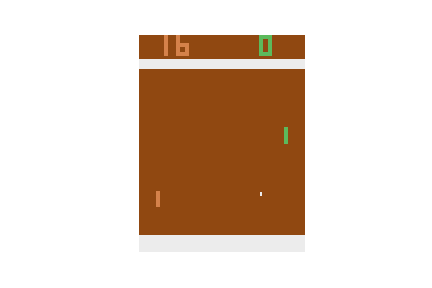
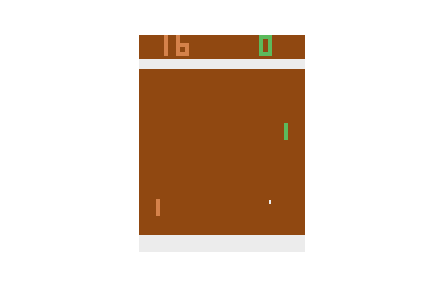
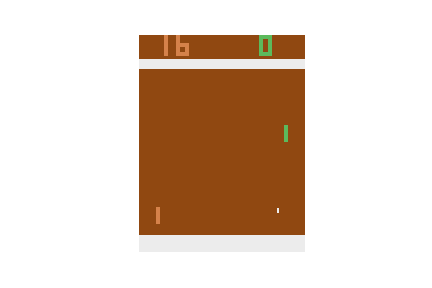
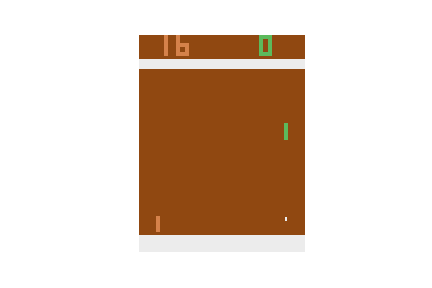
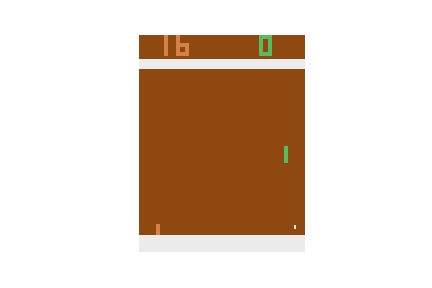
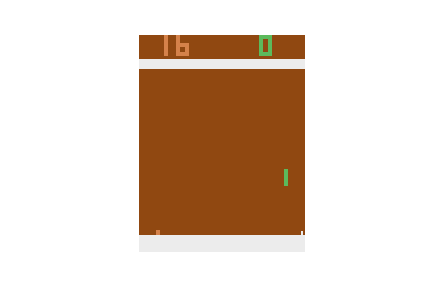
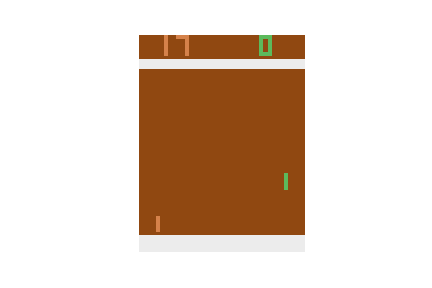
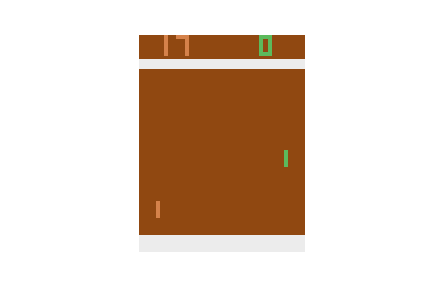
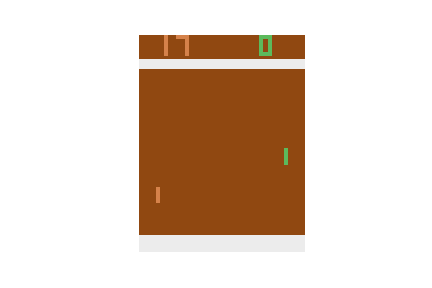
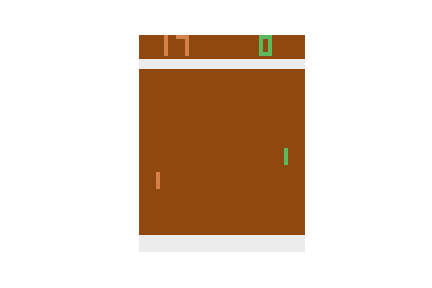
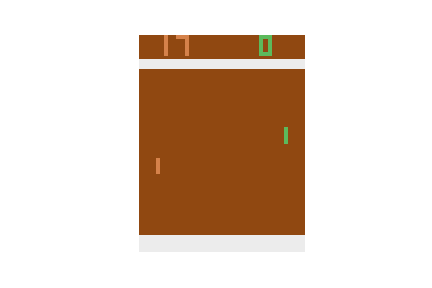
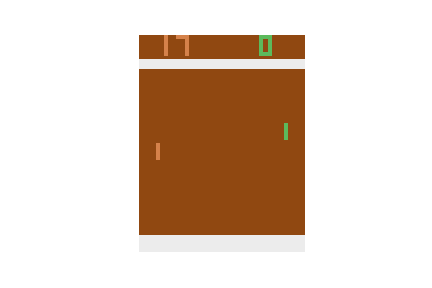
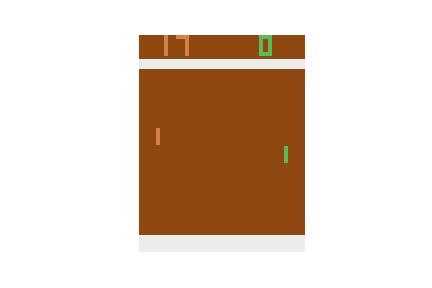
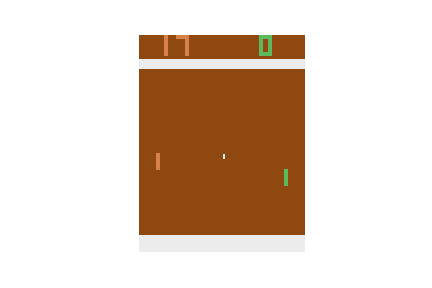
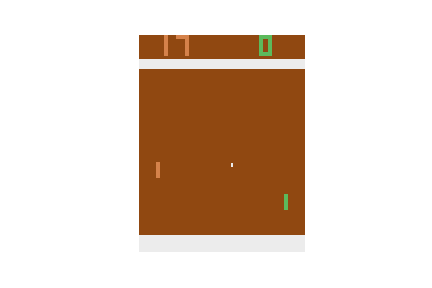
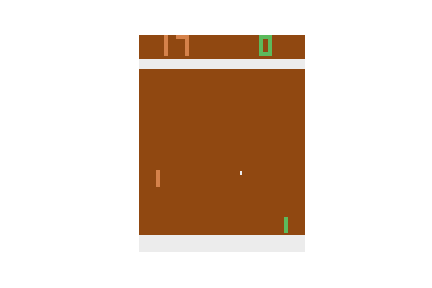
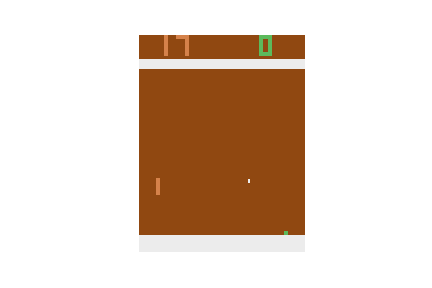
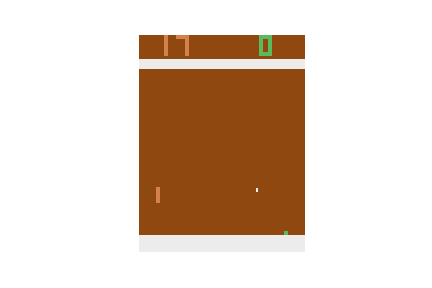
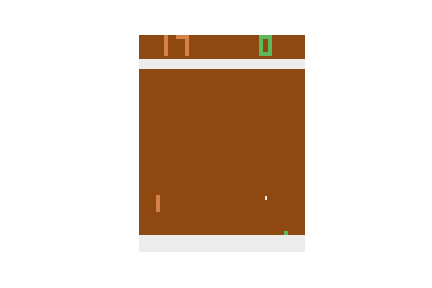
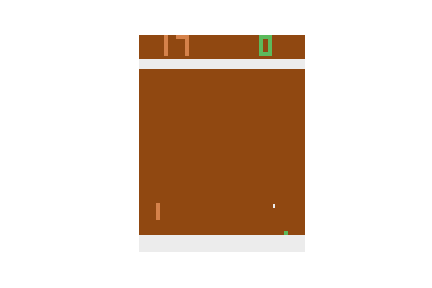
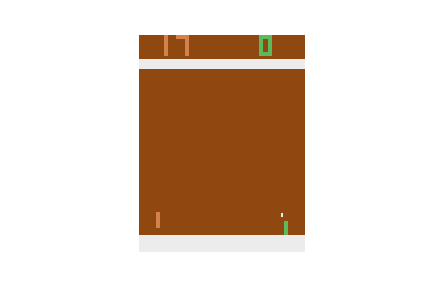
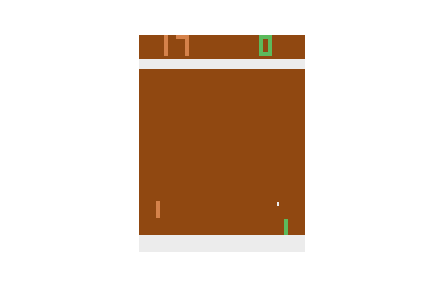
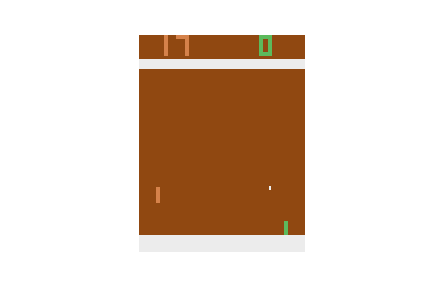
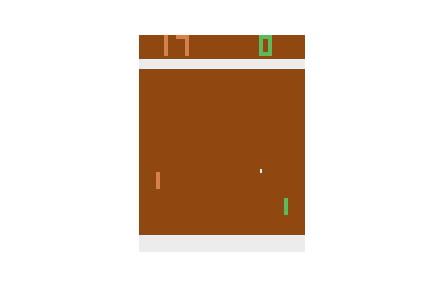
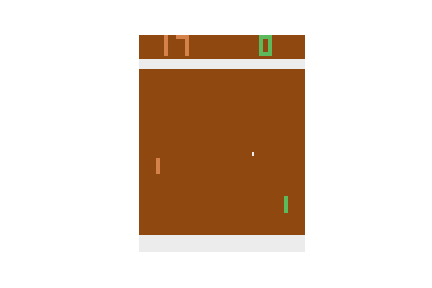
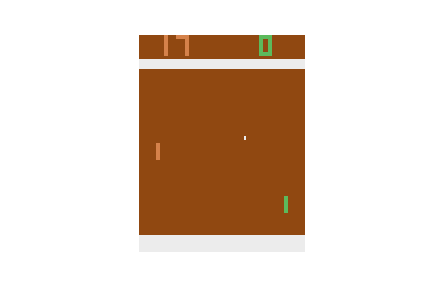
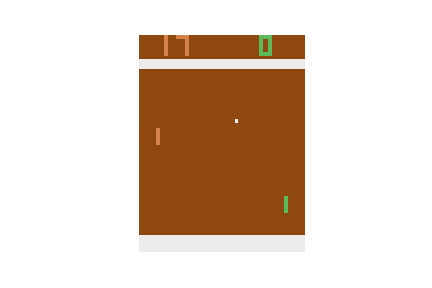
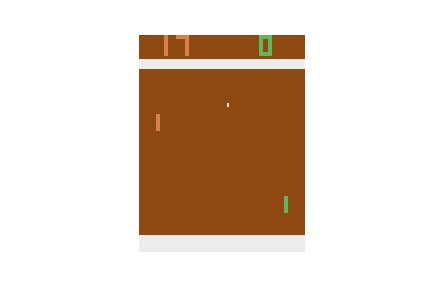
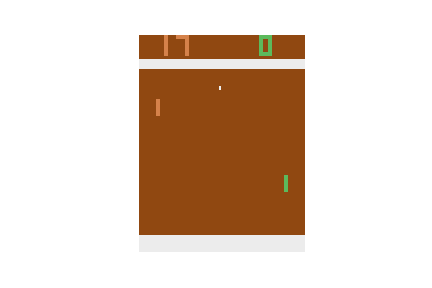
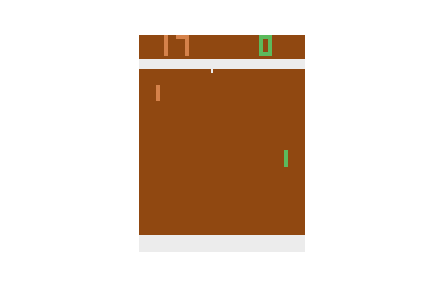
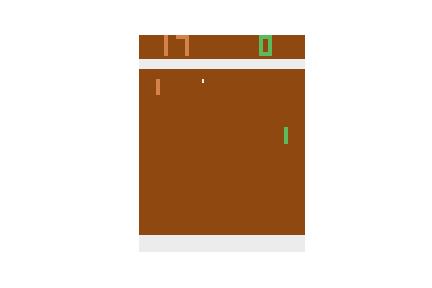
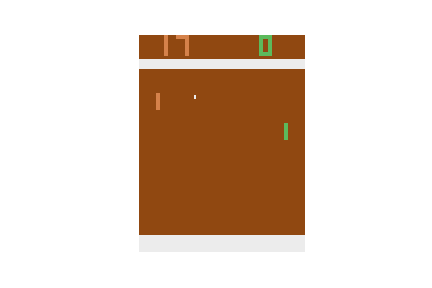
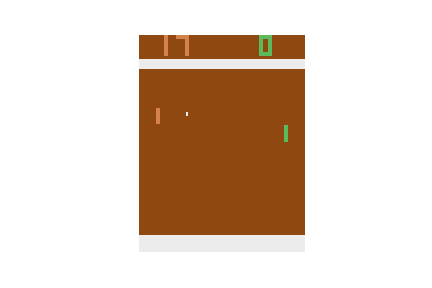
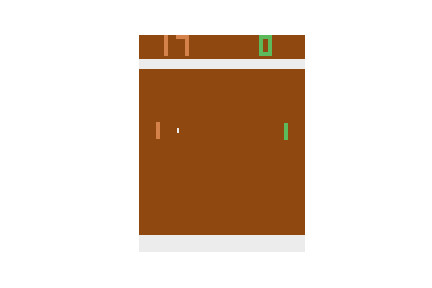
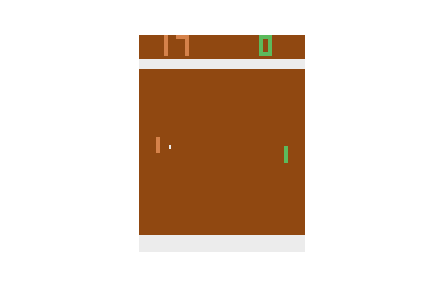
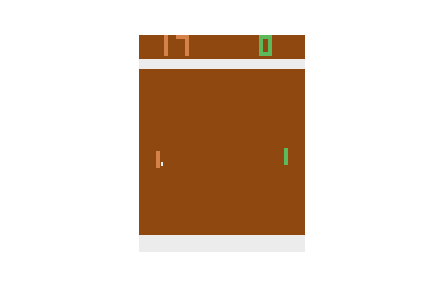
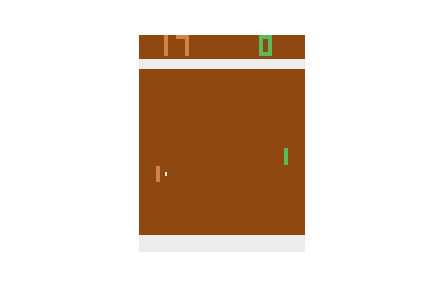
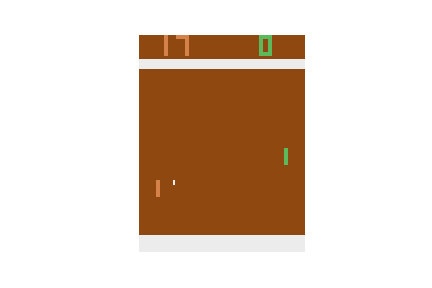
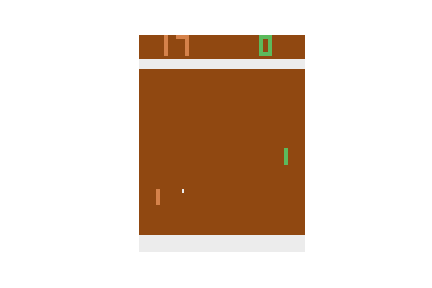
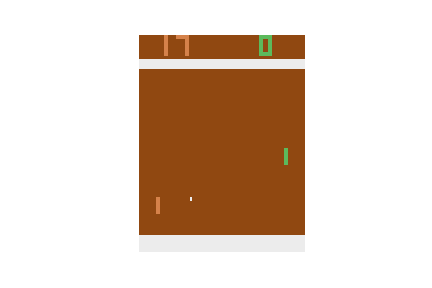
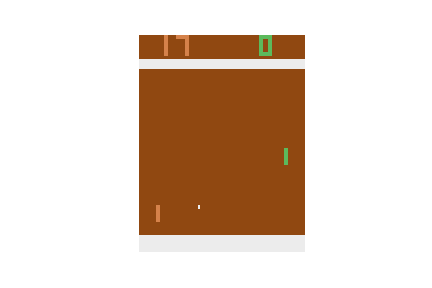
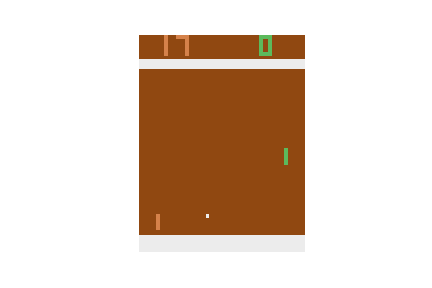
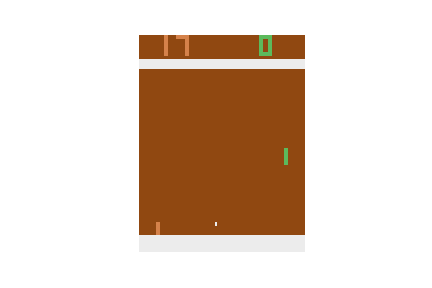
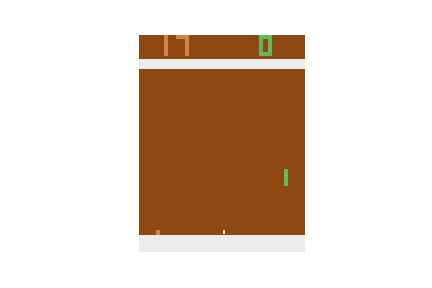
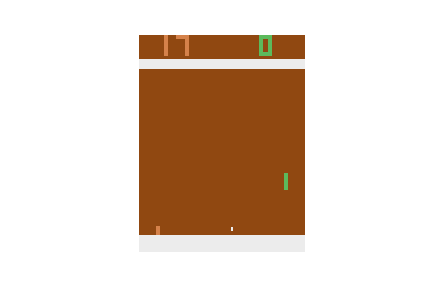
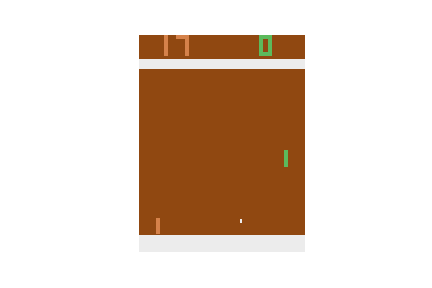
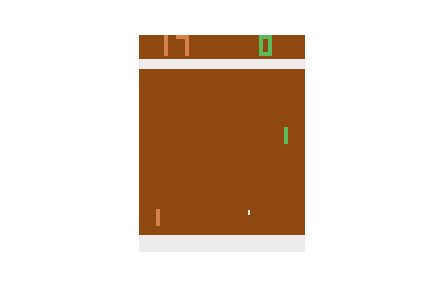
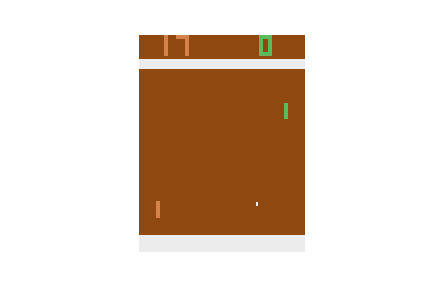
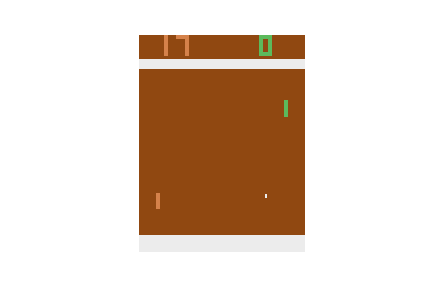
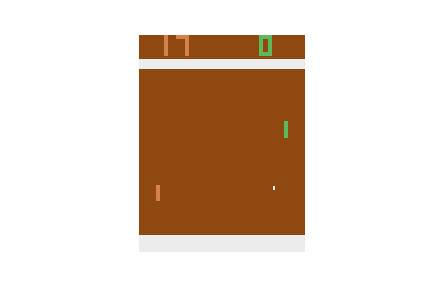
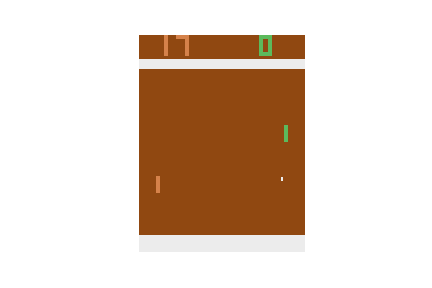
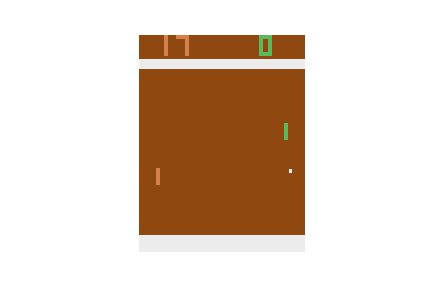
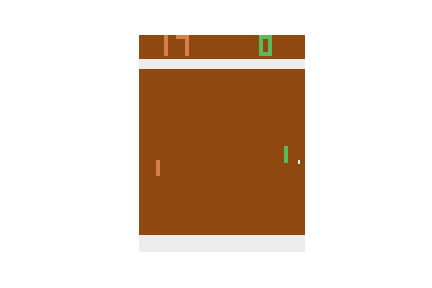
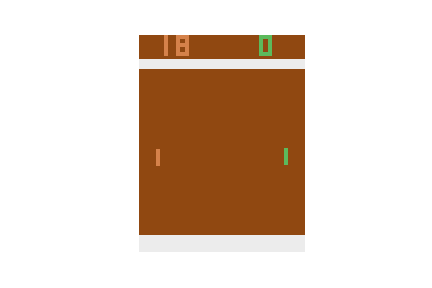
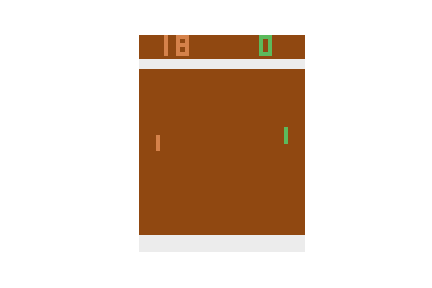
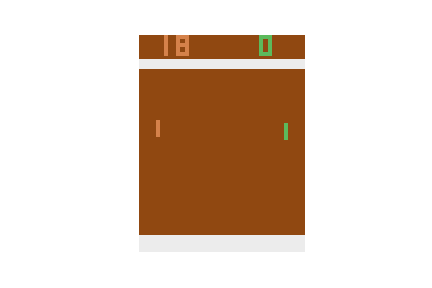
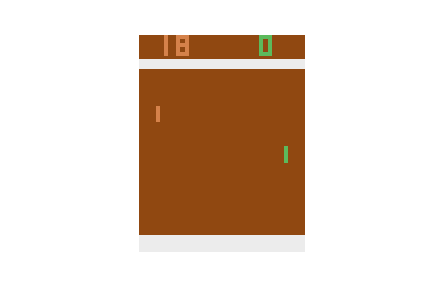
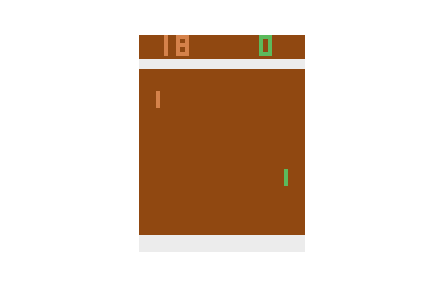
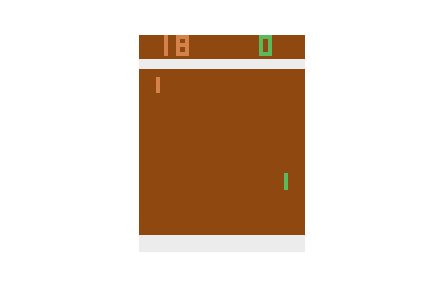
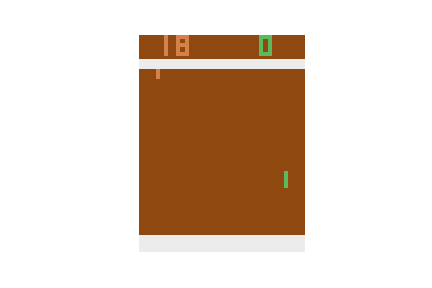
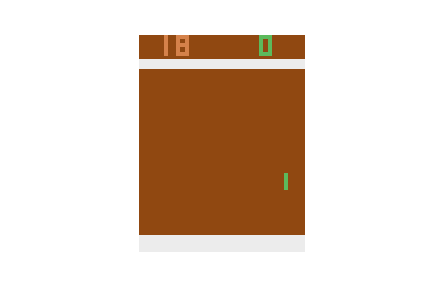
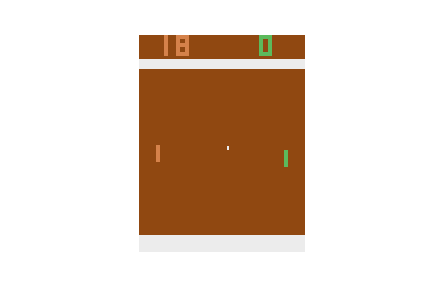
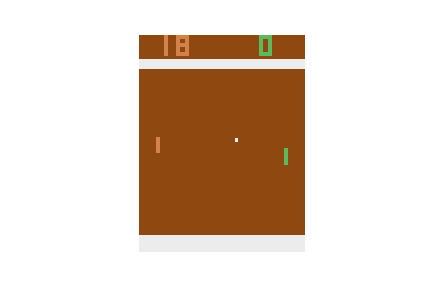
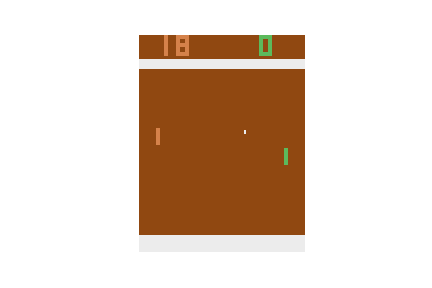
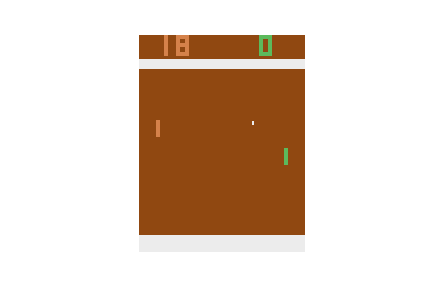
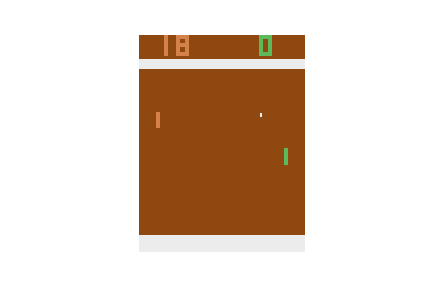
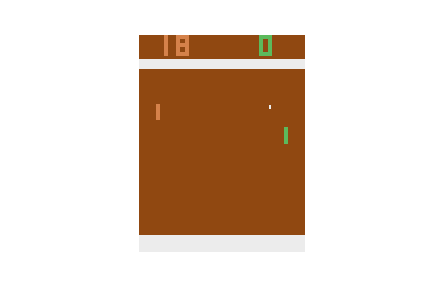
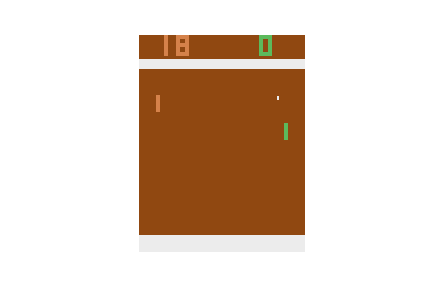
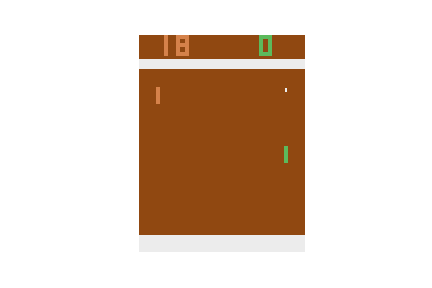
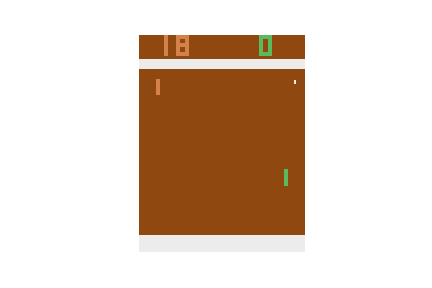
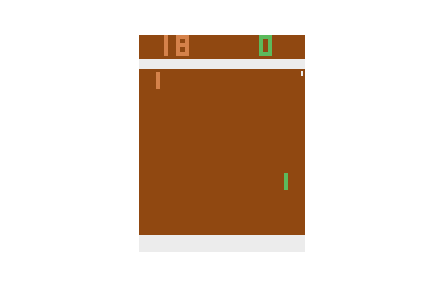
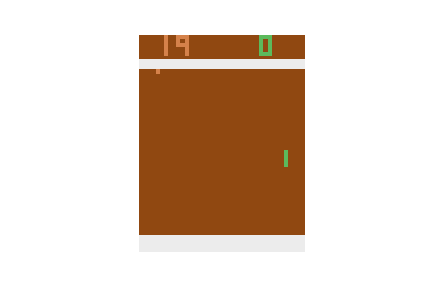
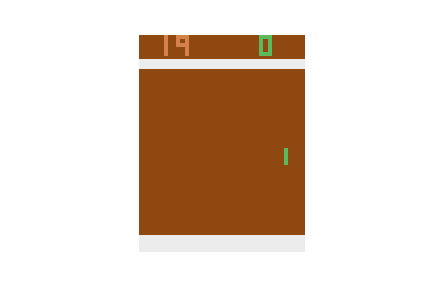
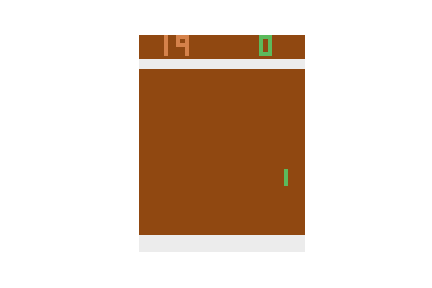
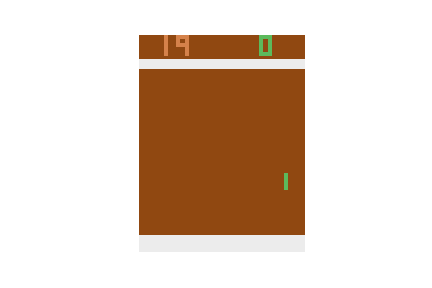
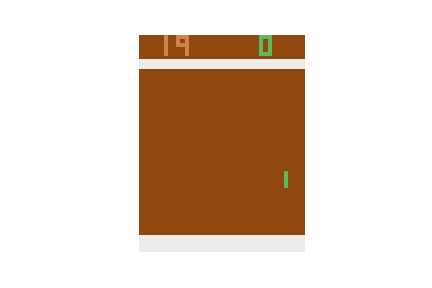
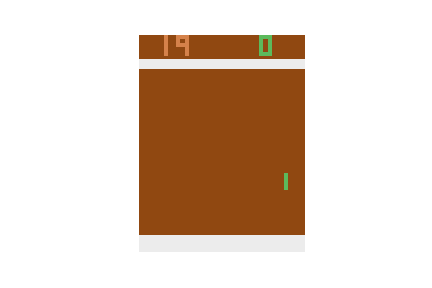
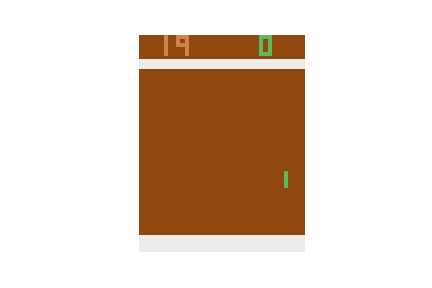
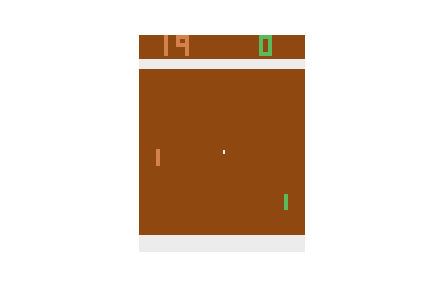
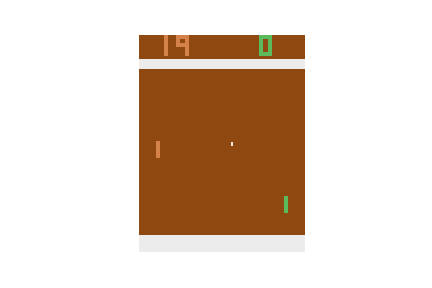
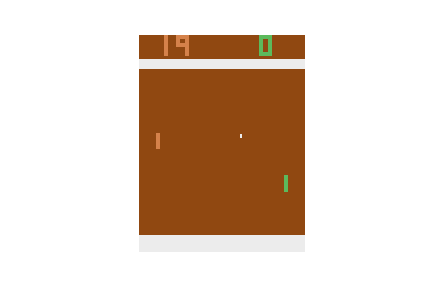
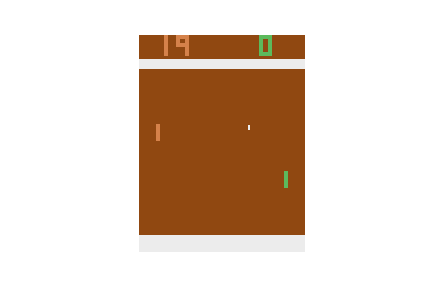
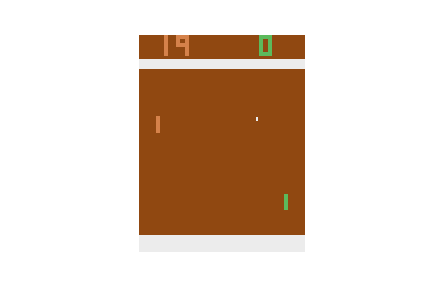
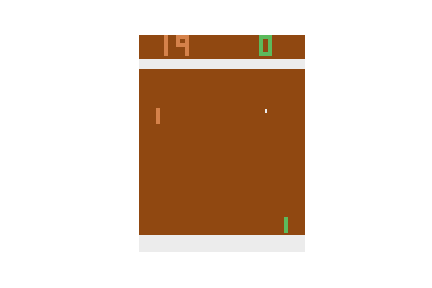
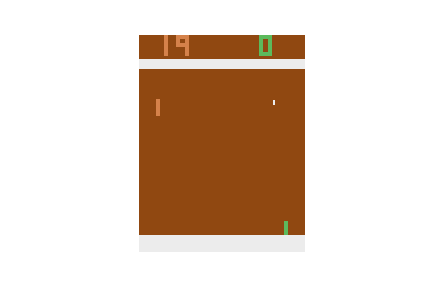
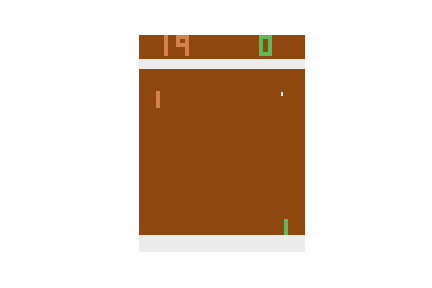
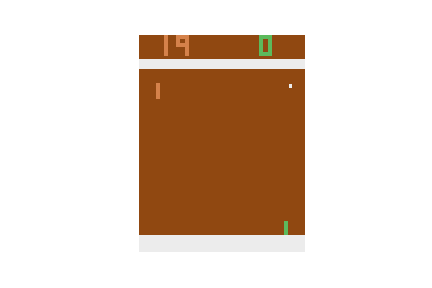
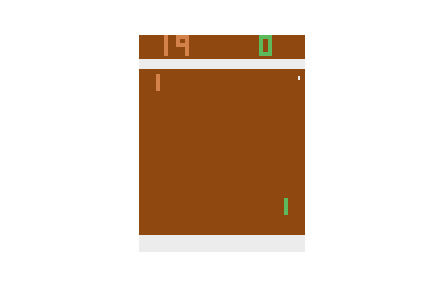
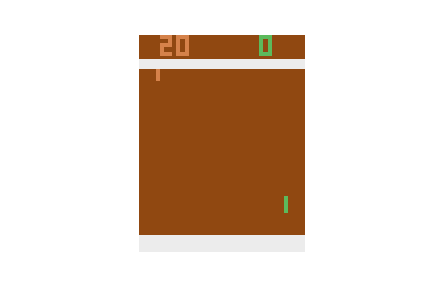
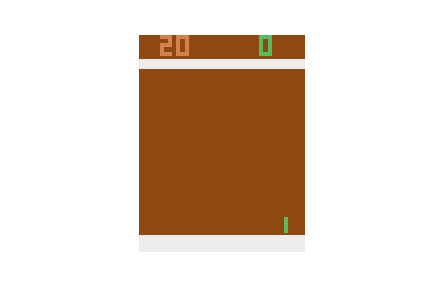
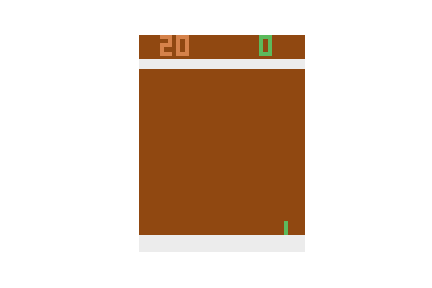
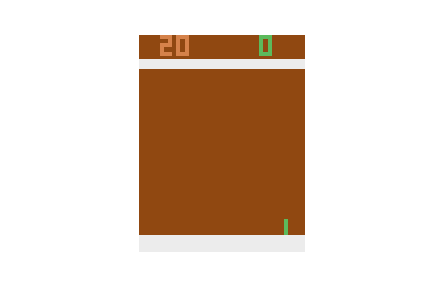
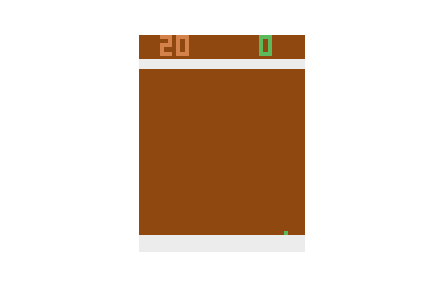
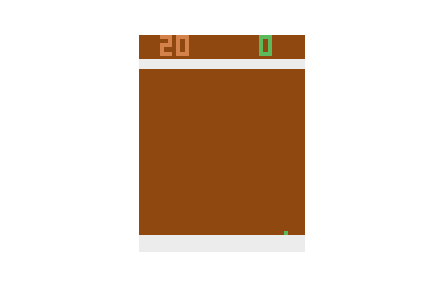
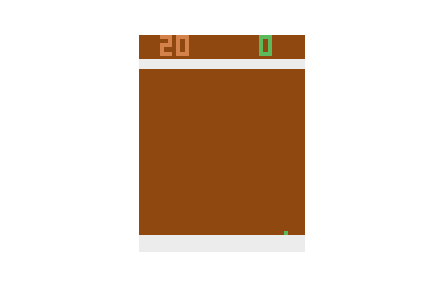
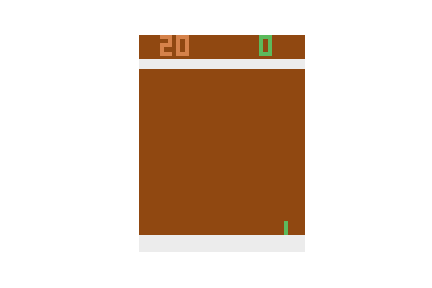
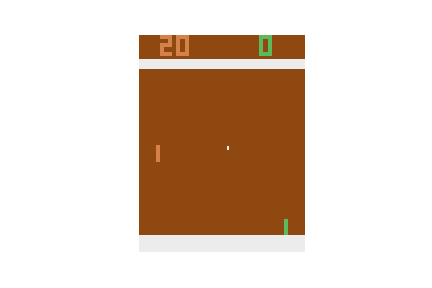
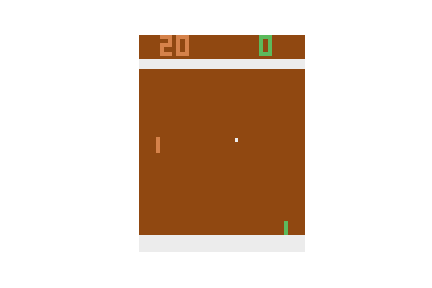
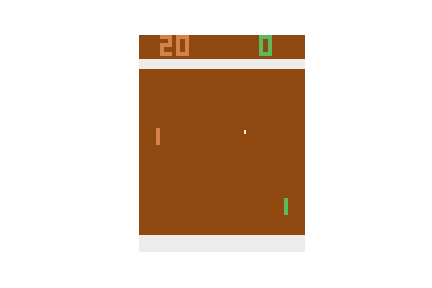
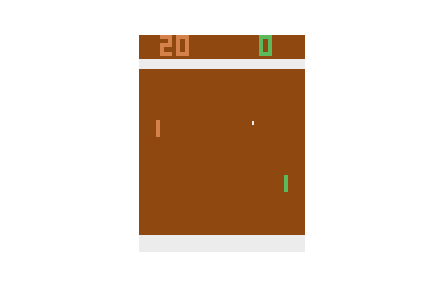
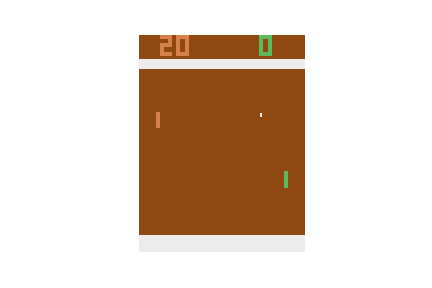
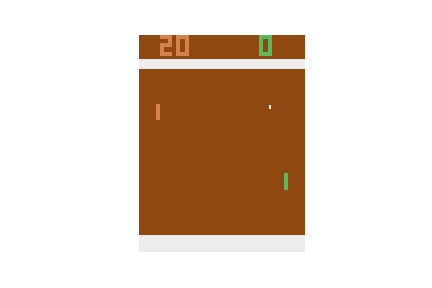
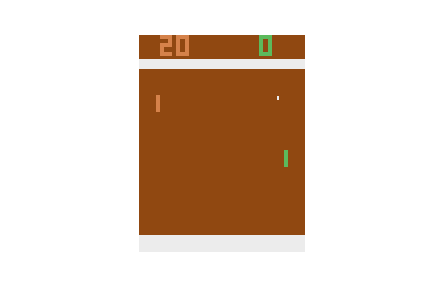
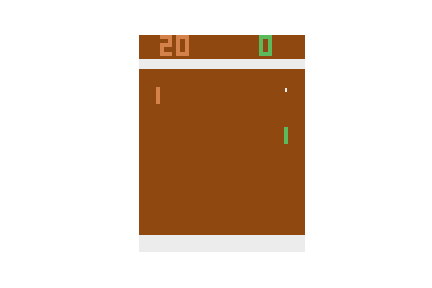
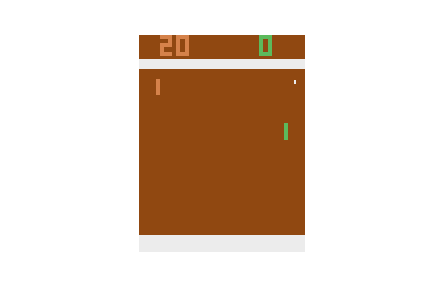
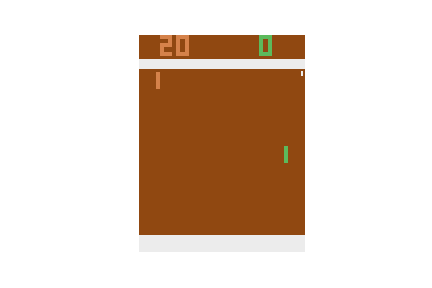

In [5]:
pong_utils.play(env, policy, time=500) 
# try to add the option "preprocess=pong_utils.preprocess_single"
# to see what the agent sees

# Rollout
Before we start the training, we need to collect samples. To make things efficient we use parallelized environments to collect multiple examples at once

Amir note: this is how we collect samples of the policy behavior at its current parameter setting. 

In [6]:
envs = pong_utils.parallelEnv('PongDeterministic-v4', n=4, seed=100)
prob, state, action, reward = pong_utils.collect_trajectories(envs, policy, tmax=100)

# Note: 
#    - prob shape is (tmax x n) 
#    - state shape is (tmax x n x 2 x 80 x 80)  
#    - action shape is (tmax x n)
#    - reward shape is (tmax x n)

/media/Data/env/pong-env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
Process Process-4:
Process Process-2:
Process Process-1:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*se

# Function Definitions
Here you will define key functions for training. 

## Exercise 2: write your own function for training
(this is the same as policy_loss except the negative sign)

### REINFORCE
you have two choices (usually it's useful to divide by the time since we've normalized our rewards and the time of each trajectory is fixed)

1. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\log(\pi_{\theta'}(a_t|s_t))$
2. $\frac{1}{T}\sum^T_t R_{t}^{\rm future}\frac{\pi_{\theta'}(a_t|s_t)}{\pi_{\theta}(a_t|s_t)}$ where $\theta'=\theta$ and make sure that the no_grad is enabled when performing the division

In [16]:
from pong_utils import states_to_prob
import numpy as np
RIGHT=4
LEFT=5

# notice the old_probs, state, actions, etc are from multiple parallel env that ran 
# for tmax time
def surrogate(policy, old_probs, states, actions, rewards,
              discount = 0.995, beta=0.01):
    # discount.shape (tmax x 1)
    discount = discount**np.arange(len(rewards))
    # Simply put, numpy.newaxis is used to increase the dimension 
    # of the existing array by one more dimension,
    # rewards.shape (tmax x threads)
    rewards = np.asarray(rewards)*discount[:,np.newaxis]
    
    # convert rewards to future rewards
    # from end we add elements so the last state reward is only the last reward
    # the first state reward is the sum of all discounted rewards
    # the cumsum function [[0] , [0]+[1] , [0]+[1]+[2] , ....] 
    # at the end we revert back [[r0+r1+...+rn] , [r1+...+rn], ..., [rn]]
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    
    mean = np.mean(rewards_future, axis=1)
#     print("mean", mean.shape)
    std = np.std(rewards_future, axis=1) + 1.0e-10
#     print("std", std.shape)
    rewards_normalized = (rewards_future - mean[:,np.newaxis])/std[:,np.newaxis]
#     print("rewards_normalized", rewards_normalized.shape)
    # convert everything into pytorch tensors and move to gpu if available

    
    # Note: 
    #    - prob shape is (tmax x threads) 
    #    - state shape is (tmax x threads x 2 frames x 80 width x 80 height)  
    #    - action shape is (tmax x threads)
    #    - reward shape is (tmax x threads)
    actions = torch.tensor(actions, dtype=torch.int8, device=device)
    old_probs = torch.tensor(old_probs, dtype=torch.float, device=device)
    rewards = torch.tensor(rewards_normalized, dtype=torch.float, device=device)
    # convert states to policy (or probability)
    # notice here the actions are already taken in the roll-out session. 
    # all we are trying to get here is the tensor corresponding with the model
    # the model spits out action probabilities. Old_probs only are numerical values
    # they are not attached to any model. 
    new_probs = states_to_prob(policy, states)
    new_probs = torch.where(actions == RIGHT, new_probs, 1.0-new_probs)

    ratio = new_probs/old_probs
#     print(torch.mean(ratio).detach().cpu().numpy())
    # include a regularization term
    # this steers new_policy towards 0.5
    # add in 1.e-10 to avoid log(0) which gives nan
    # see paper https://arxiv.org/pdf/1707.06347.pdf 
    # which explains why the loss below is unstable
    # entropy = -(rewards*torch.log(new_probs+1.e-10))
    # a more stable loss function was introduced in the same paper:
    # This is called Kullback–Leibler divergence
    entropy = -(new_probs*torch.log(old_probs+1.e-10)+ \
               (1.0-new_probs)*torch.log(1.0-old_probs+1.e-10))
#     print((ratio*rewards).shape)
#     print(torch.mean(ratio*rewards + beta*entropy))
    return torch.mean(ratio*rewards + beta*entropy)




    
Lsur= surrogate(policy, prob, state, action, reward)

print(Lsur)

torch.Size([100, 4])
tensor(1.00000e-03 *
       6.9126, device='cuda:0')
tensor(1.00000e-03 *
       6.9126, device='cuda:0')


# Training
We are now ready to train our policy!
WARNING: make sure to turn on GPU, which also enables multicore processing. It may take up to 45 minutes even with GPU enabled, otherwise it will take much longer!

In [9]:
from parallelEnv import parallelEnv
import numpy as np
# WARNING: running through all 800 episodes will take 30-45 minutes

# training loop max iterations
episode = 1200

# widget bar to display progress
!pip install progressbar
import progressbar as pb
widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=episode).start()

# initialize environment
envs = parallelEnv('PongDeterministic-v4', n=6, seed=1234)

discount_rate = .99
beta = .01
tmax = 500

# keep track of progress
mean_rewards = []
old_probs, states, actions, rewards = \
    pong_utils.collect_trajectories(envs, policy, tmax=tmax)
for e in range(episode):

    
    total_rewards = np.sum(rewards, axis=0)

    # this is the SOLUTION!
    # use your own surrogate function
#     L = -surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    
    L = -pong_utils.surrogate(policy, old_probs, states, actions, rewards, beta=beta)
    old_probs, states, actions, rewards = \
                                pong_utils.collect_trajectories(envs, policy, tmax=tmax)
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    del L
        
    # the regulation term also reduces
    # this reduces exploration in later runs
    beta*=.995
    
    # get the average reward of the parallel environments
    mean_rewards.append(np.mean(total_rewards))
    
    # display some progress every 20 iterations
    if (e+1)%20 ==0 :
        print("Episode: {0:d}, score: {1:f}".format(e+1,np.mean(total_rewards)))
#         print(total_rewards)
        
    # update progress widget bar
    timer.update(e+1)
    
timer.finish()
    

/media/Data/env/pong-env/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


average batch ration: 1.0


average batch ration: 1.0000190734863281


average batch ration: 1.0000263452529907


average batch ration: 1.0000121593475342


average batch ration: 1.0000066757202148


average batch ration: 0.9999983310699463


average batch ration: 1.000025749206543


average batch ration: 1.0000145435333252


average batch ration: 1.000029444694519


average batch ration: 0.9999970197677612


average batch ration: 0.999995231628418


average batch ration: 1.0000044107437134


average batch ration: 0.9999911785125732


average batch ration: 0.9999986886978149


average batch ration: 0.9999716281890869


average batch ration: 0.9999805688858032


average batch ration: 1.0000426769256592


average batch ration: 1.0000367164611816


average batch ration: 1.0000475645065308


average batch ration: 1.0000152587890625


Episode: 20, score: -20.333333
average batch ration: 0.9999762773513794


average batch ration: 1.0000004768371582


average batch ration: 1.0000240802764893


average batch ration: 1.000008225440979


average batch ration: 0.9999796152114868


average batch ration: 1.0000004768371582


average batch ration: 1.0000053644180298


Process Process-11: |                                           | ETA:  0:49:54
Process Process-12:
Process Process-13:
Traceback (most recent call last):
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/media/Data/deep-reinforcement-learning/Pong_reinforce/parallelEnv.py", line 104, in worker
    cmd, data = remote.recv()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/connection.py", line 250, in recv
    buf = self._recv_bytes()


KeyboardInterrupt: 

Traceback (most recent call last):
Traceback (most recent call last):
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/connection.py", line 407, in _recv_bytes
    buf = self._recv(4)
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/connection.py", line 379, in _recv
    chunk = read(handle, remaining)
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/media/Data/env/pong-env/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
KeyboardInterrupt
  File "/media/Data/deep-reinforcement-learning/Pong_reinforce/parallelEnv.py", line 104, in worker
    cmd, data = remote.recv()
  File "/media

In [ ]:
# play game after training!
pong_utils.play(env, policy, time=500) 

In [ ]:
plt.plot(mean_rewards)

In [ ]:
# save your policy!
torch.save(policy, 'REINFORCE.policy')

# load your policy if needed
# policy = torch.load('REINFORCE.policy')

# try and test out the solution!
# policy = torch.load('PPO_solution.policy')